In [1]:
import sys
sys.path.append('..')

In [2]:
import torch
import pickle
import yaml
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data.dataloader import DataLoader
from reaction_predictors.graph_model.models import RGCNNTrClassifier
from utils.graph_utils import get_bonds, get_nodes
from utils.torch_dataset import Dataset, graph_collate
from utils.draw_utils import draw_gt_reaction
from reaction_predictors.graph_model.model_utils import train_epoch, evaluate, test
from collections import namedtuple

/home/socrates/miniconda3/envs/chem/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/home/socrates/miniconda3/envs/chem/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/home/socrates/miniconda3/envs/chem/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/home/socrates/miniconda3/envs/chem/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/home/socrates/miniconda3/envs/chem/lib/python3.6/importlib/_boo

In [3]:
from rdkit.Chem.Draw import rdMolDraw2D
from rdkit.Chem.Draw import IPythonConsole
from IPython.display import SVG, Image
IPythonConsole.molSize = (400,400)

In [4]:
import sklearn
import umap
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

/home/socrates/miniconda3/envs/chem/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/home/socrates/miniconda3/envs/chem/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [5]:
def prune_dataset_by_length(dataset, max_len):
    new_dataset = {}
    for idx in dataset:
        r_mask = dataset[idx]['reactants']['mask']
        r_mask = r_mask[r_mask > 0]
        if len(dataset[idx]['target_main_product']) <= max_len and len(np.unique(r_mask)) == len(r_mask):
            new_dataset[idx] = dataset[idx]
    return new_dataset

In [6]:
def convert(dictionary):
    for key, value in dictionary.items():
        if isinstance(value, dict):
            dictionary[key] = convert(value)
    return namedtuple('GenericDict', dictionary.keys())(**dictionary)

In [7]:
with open('../scripts/graph_models/MT_EGBF_sm_vis.yml', 'r') as ymlfile:
    config = yaml.load(ymlfile, Loader=yaml.FullLoader)

In [8]:
device = 'cuda:2'
model_cfg = convert(config["model"])
data_cfg = convert(config["dataset"])
train_cfg = convert(config["train"])
paths = convert(config["paths"])

In [9]:
meta = pickle.load(open(paths.dataset_path + 'meta.pkl', 'rb'))

node2label = get_nodes(meta['node'], n_molecule_level=data_cfg.n_molecule_level,
                       n_reaction_level=data_cfg.n_reaction_level)
bond2label = get_bonds(meta['type'], n_molecule_level=data_cfg.n_molecule_level,
                       n_reaction_level=data_cfg.n_reaction_level,
                       self_bond=data_cfg.self_bond)

In [10]:
num_rels = len(bond2label)
pad_length = data_cfg.max_num_atoms + 15 * data_cfg.n_molecule_level + \
             data_cfg.n_molecule_level * data_cfg.n_reaction_level
num_nodes = pad_length

In [11]:
model =torch.load(paths.save_path)
model = model.to(device)

In [12]:
test_dataset = pickle.load(open(paths.dataset_path + 'test.pkl', 'rb'))
test_dataset = prune_dataset_by_length(test_dataset, data_cfg.max_num_atoms)
ts_dataset = Dataset(test_dataset, device=device, pad_length=pad_length,
                         bond2label=bond2label, node2label=node2label, feature_idxs=data_cfg.feature_idxs,
                         target_main_product=data_cfg.target_main_product, target_center=data_cfg.target_center,
                         n_molecule_level=data_cfg.n_molecule_level, n_reaction_level=data_cfg.n_reaction_level)
test_loader = DataLoader(ts_dataset, train_cfg.batch_size, drop_last=True, collate_fn=graph_collate)

In [13]:
elements = "H He Li Be B C N O F Ne Na Mg Al Si P S Cl Ar K Ca Sc Ti V Cr Mn Fe Co Ni Cu Zn Ga Ge As Se Br Kr Rb Sr Y Zr Nb Mo Tc Ru Rh Pd Ag Cd In Sn Sb Te I Xe Cs Ba La Ce Pr Nd Pm Sm Eu Gd Tb Dy Ho Er Tm Yb Lu Hf Ta W Re Os Ir Pt Au Hg Tl Pb Bi Po At Rn Fr Ra Ac Th Pa U Np Pu Am Cm Bk Cf Es Fm Md No Lr Rf Db Sg Bh Hs Mt Ds Rg Cn Uut Fl Uup Lv Uus Uuo".split()
num2elem = dict(zip(range(1, len(elements)+1), elements))
elem2num = dict(zip(elements, range(1, len(elements)+1)))

In [14]:
model.eval()
representations = []
with torch.no_grad():
    for batch in test_loader:
        g = batch[0]
        h = model.embed(g.ndata['feats'].T)
        g.ndata['h'] = h
        h = model.rgcn(g).view((model.batch_size, model.n_nodes, model.h_dim))
        representations.append(h.cpu().detach().numpy())
reac_reps = np.concatenate(representations)

In [15]:
id2hidden = dict(zip(test_dataset.keys(), reac_reps))

In [16]:
reac_reps = []
id2reac = {}
for idx in id2hidden:
    n_atoms = len(test_dataset[idx]['reactants']['nodes'])
    n_molecules = len(test_dataset[idx]['reactants']['lengths']) - 1
    reac_reps.append(id2hidden[idx][n_atoms+n_molecules])
    id2reac[idx] = id2hidden[idx][n_atoms+n_molecules]
reac_reps = np.stack(reac_reps)

In [17]:
norm_reac_reps = (reac_reps.T / np.linalg.norm(reac_reps, axis=-1)).T

In [18]:
km = KMeans(n_clusters=6, ).fit(reac_reps)
km_reac = km.predict(reac_reps)

In [19]:
centers = km.cluster_centers_

In [20]:
reac_embedded = TSNE().fit_transform(reac_reps)

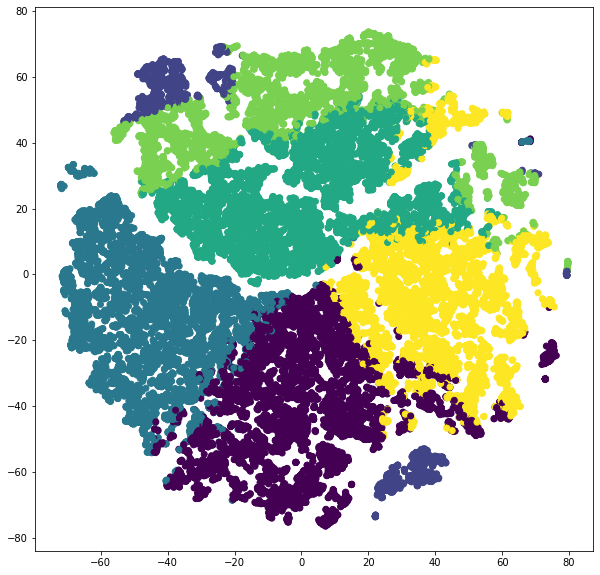

In [21]:
plt.figure(figsize=(10, 10))
plt.scatter(reac_embedded[:, 0], reac_embedded[:, 1], c=km_reac)
plt.show()

In [22]:
from scipy.spatial.distance import cosine

In [23]:
from IPython.display import display

In [24]:
def show_k_reactants(dataset, norms, indexes,):
    keys = list(dataset.keys())
    for idx in indexes:
        print(keys[idx])
        print(norms[idx])
        p, r = draw_gt_reaction(dataset[keys[idx]])
        display(SVG(p))
        display(SVG(r))

New center
6348
0.2650585


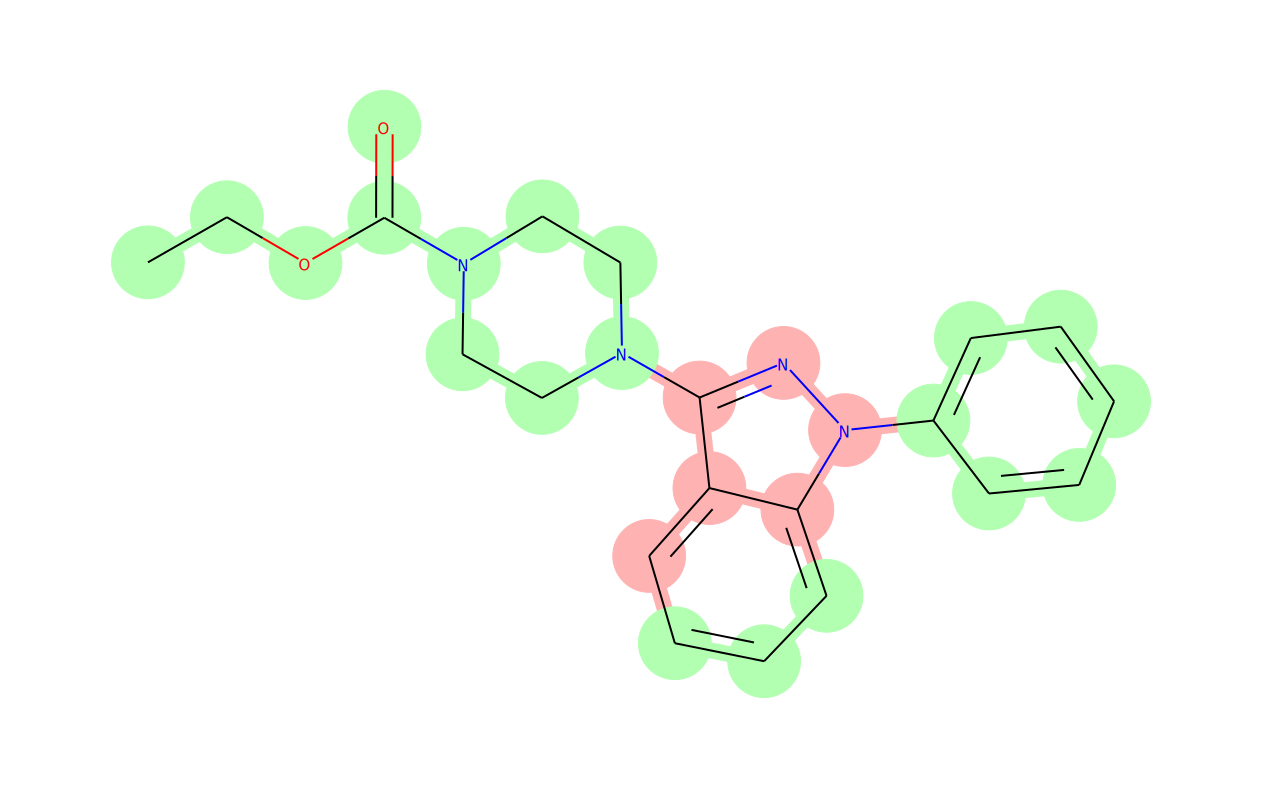

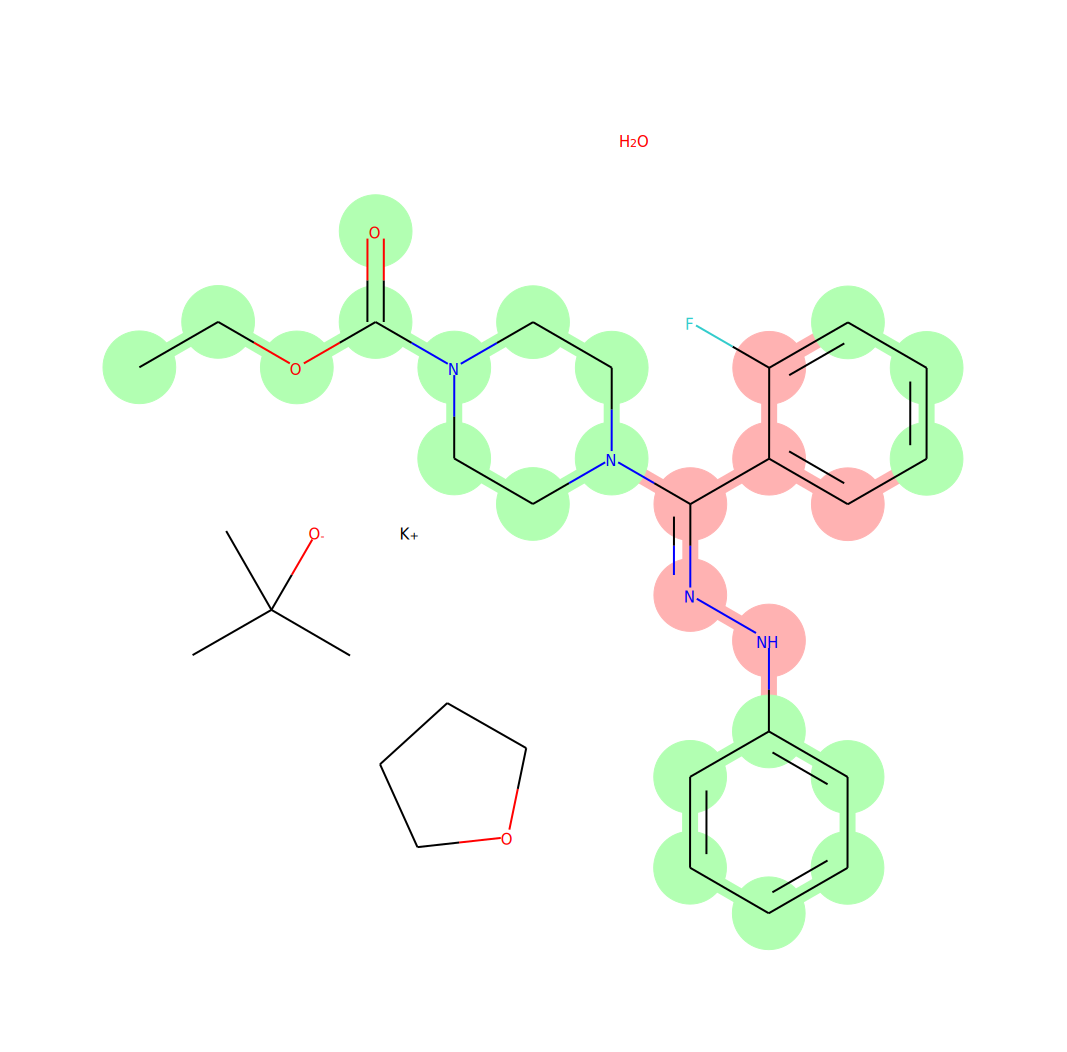

40872
0.26556736


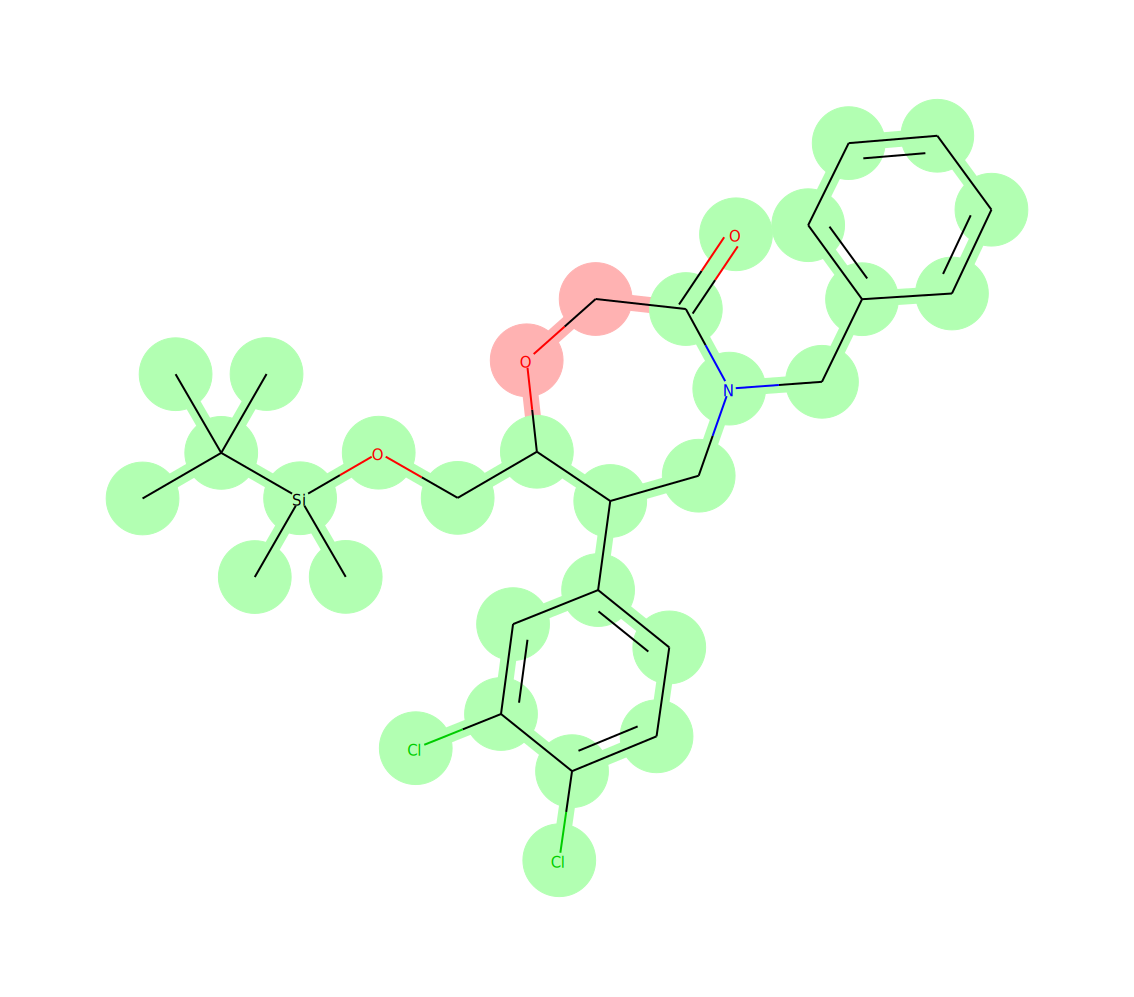

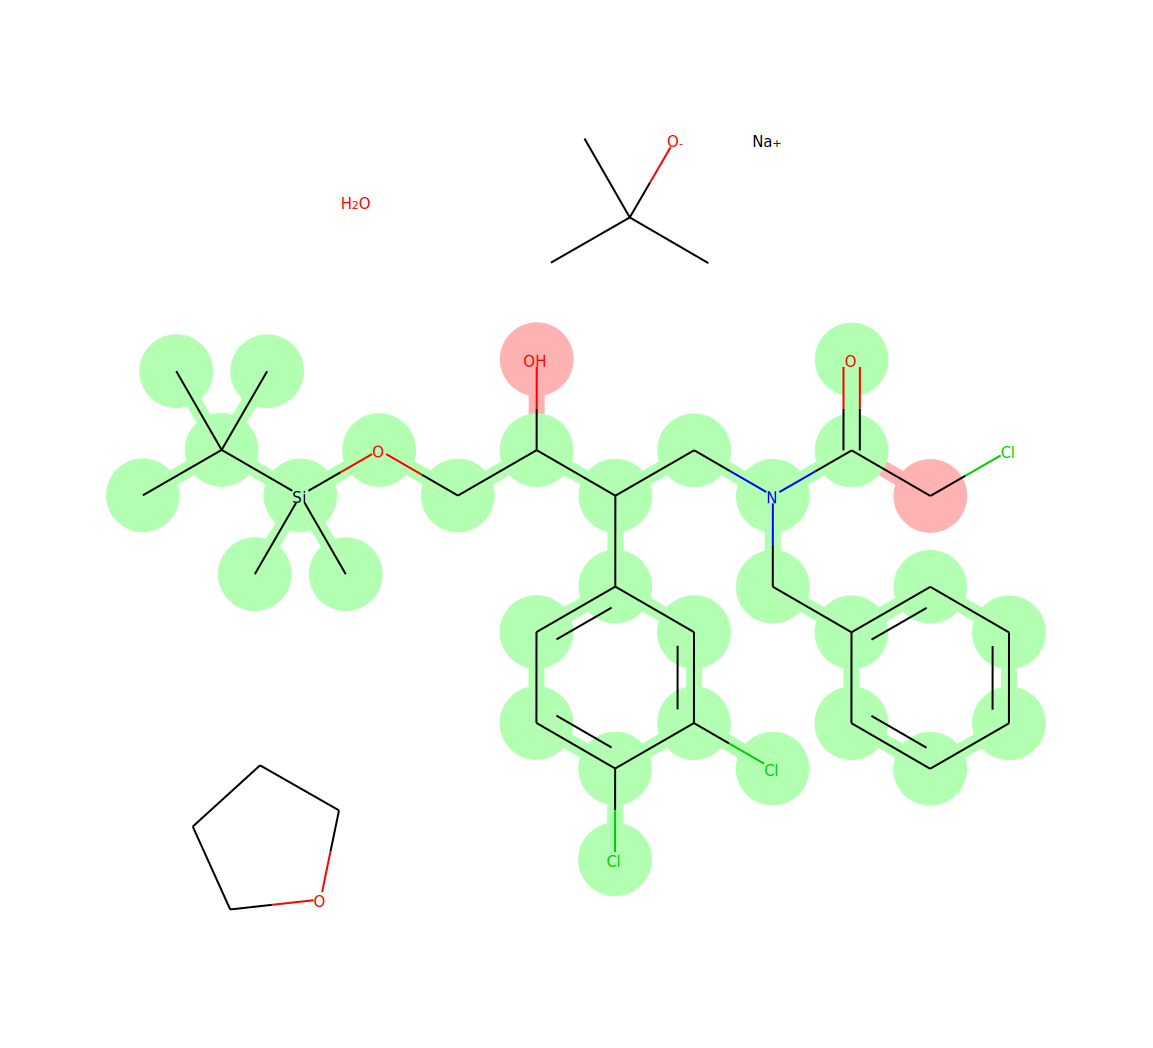

11007
0.26584253


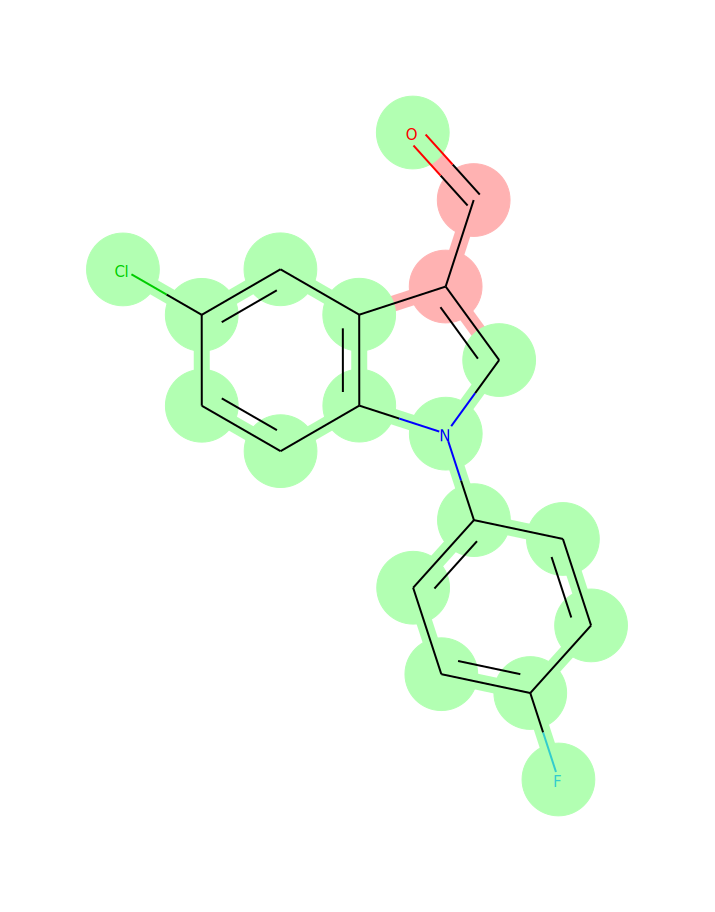

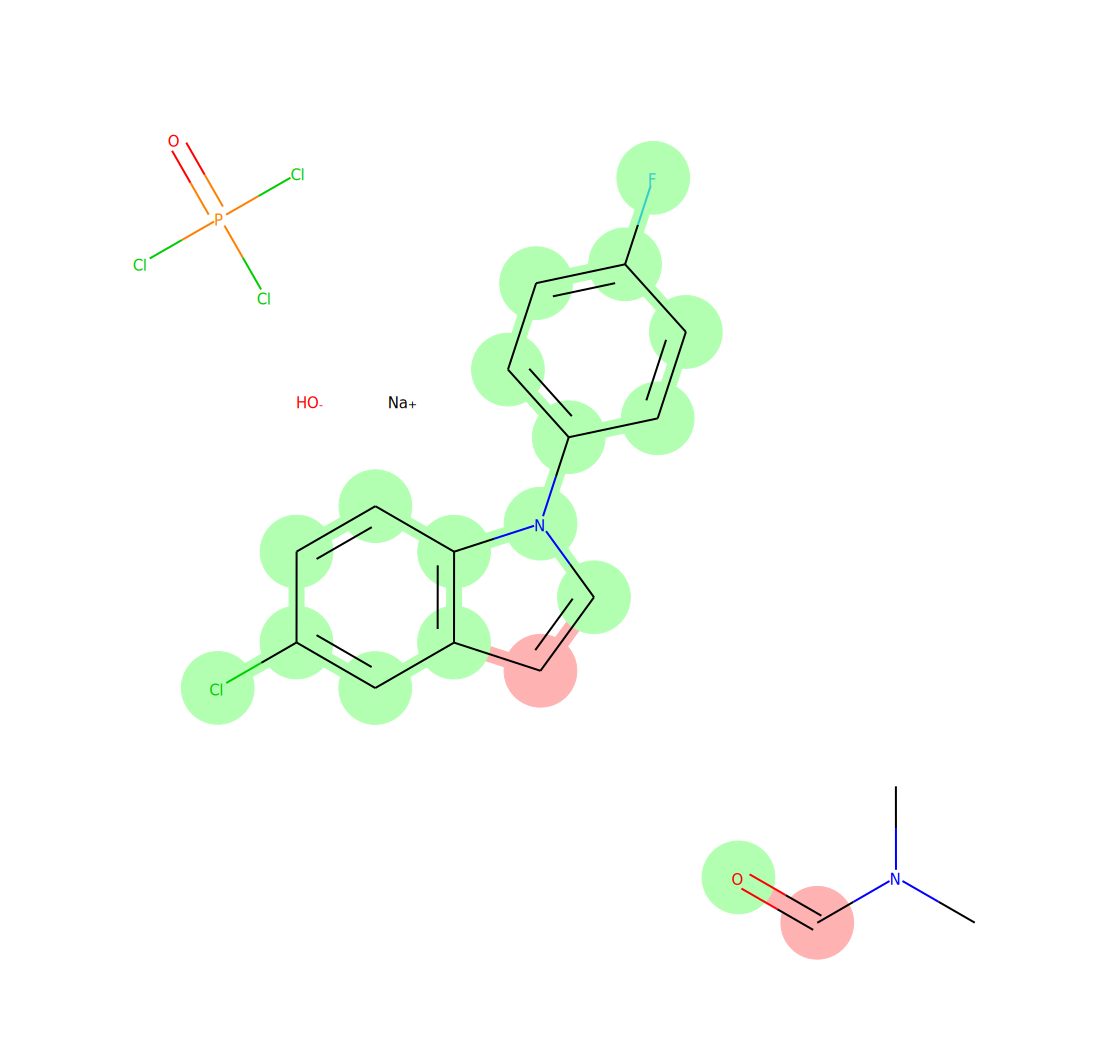

24831
0.2672814


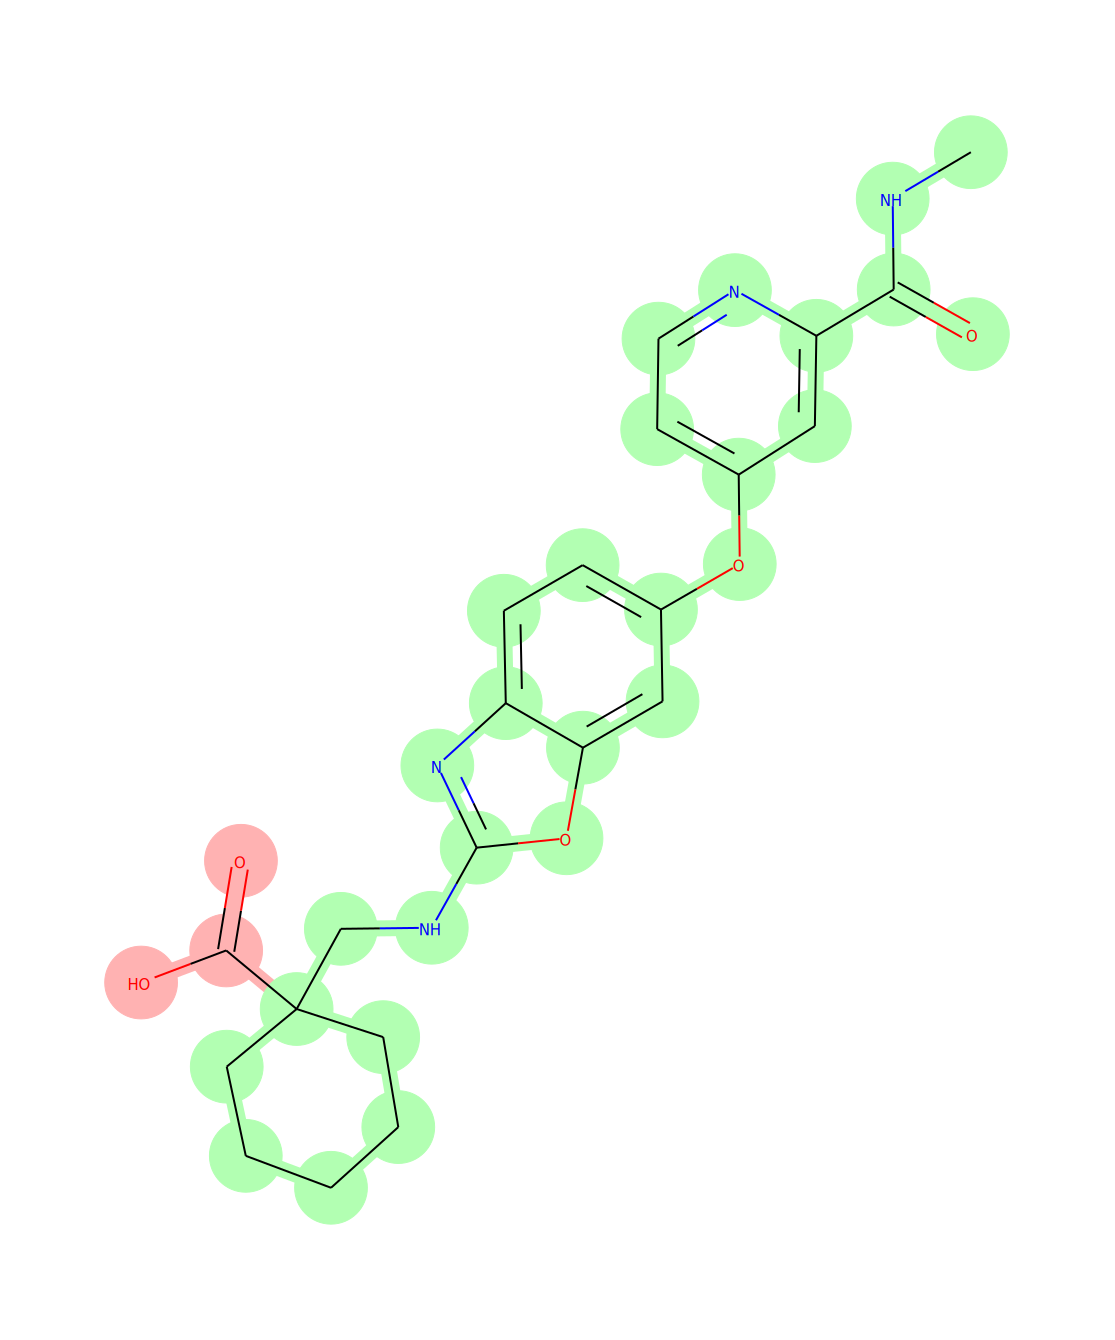

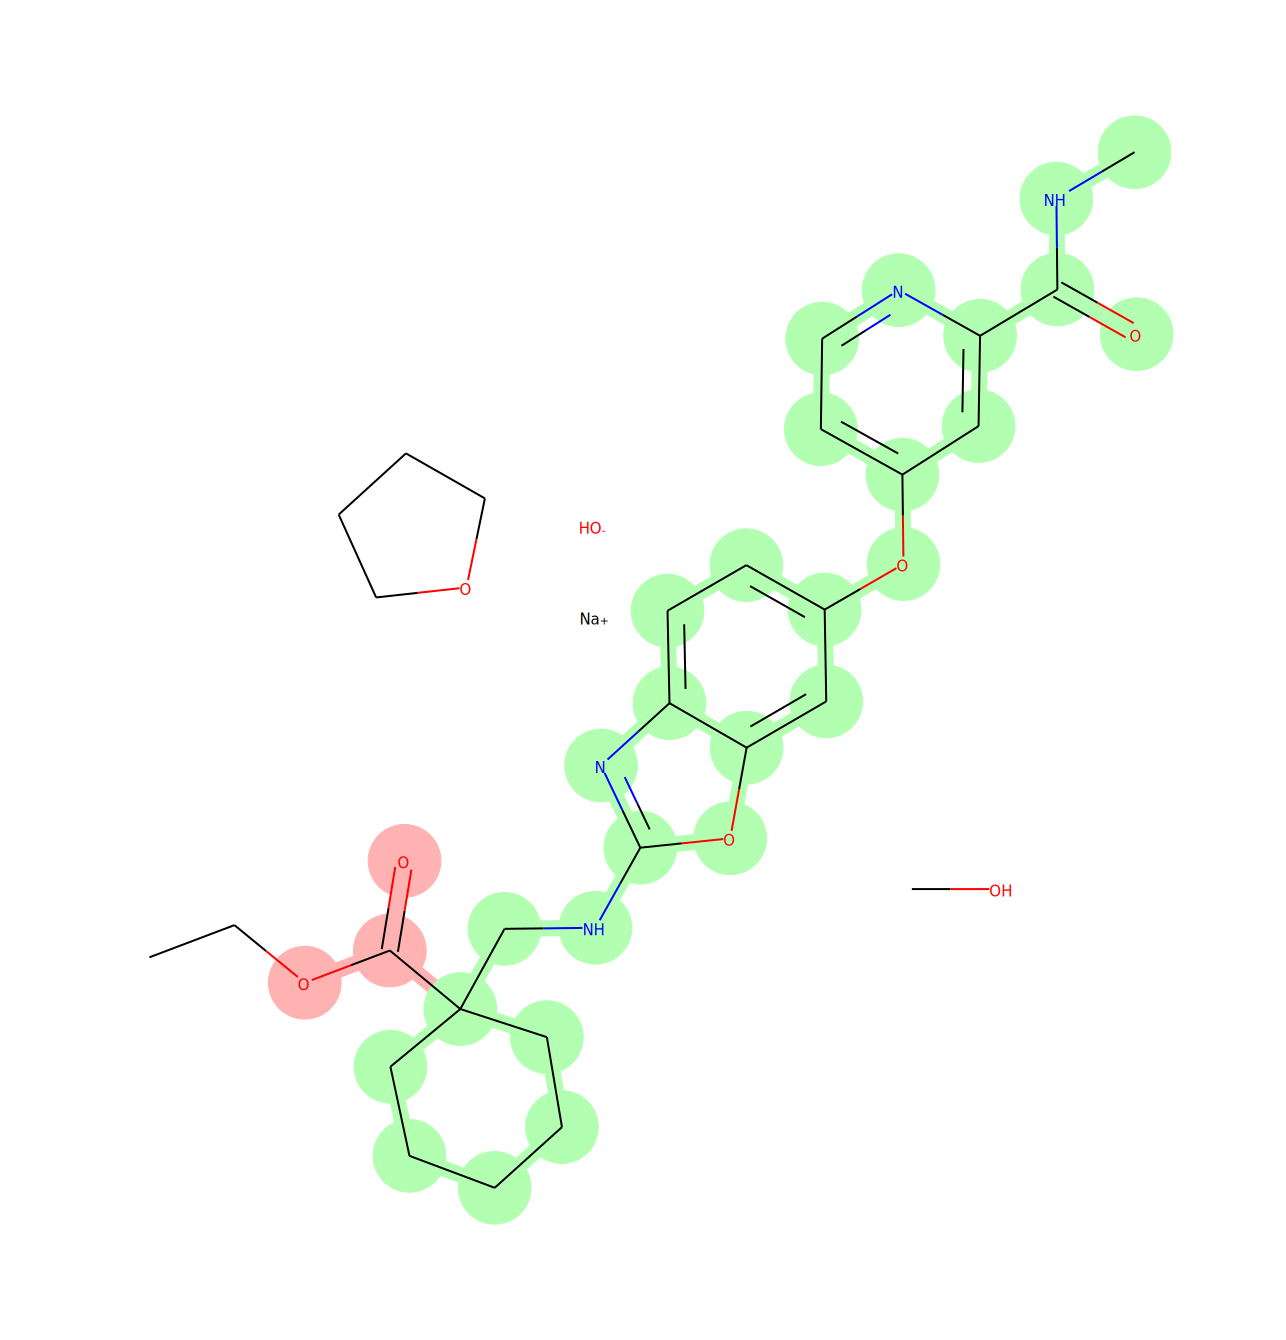

45159
0.32448444


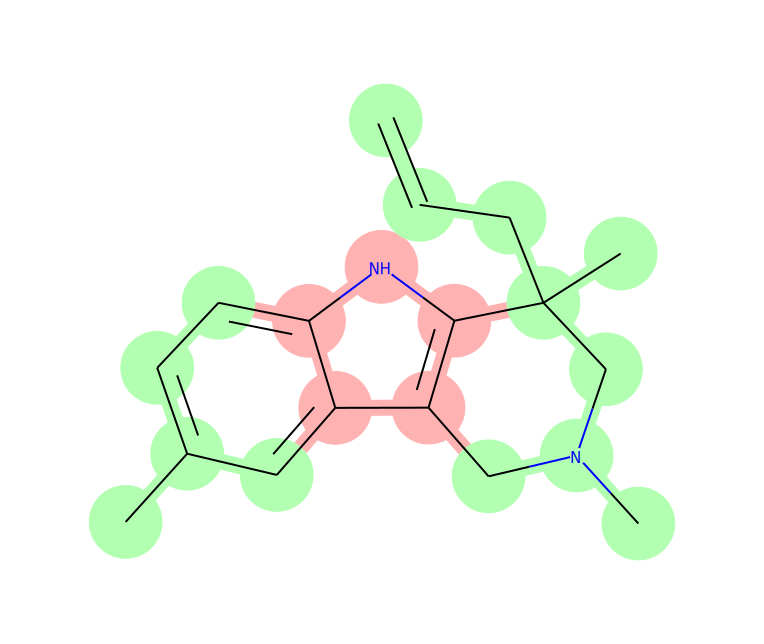

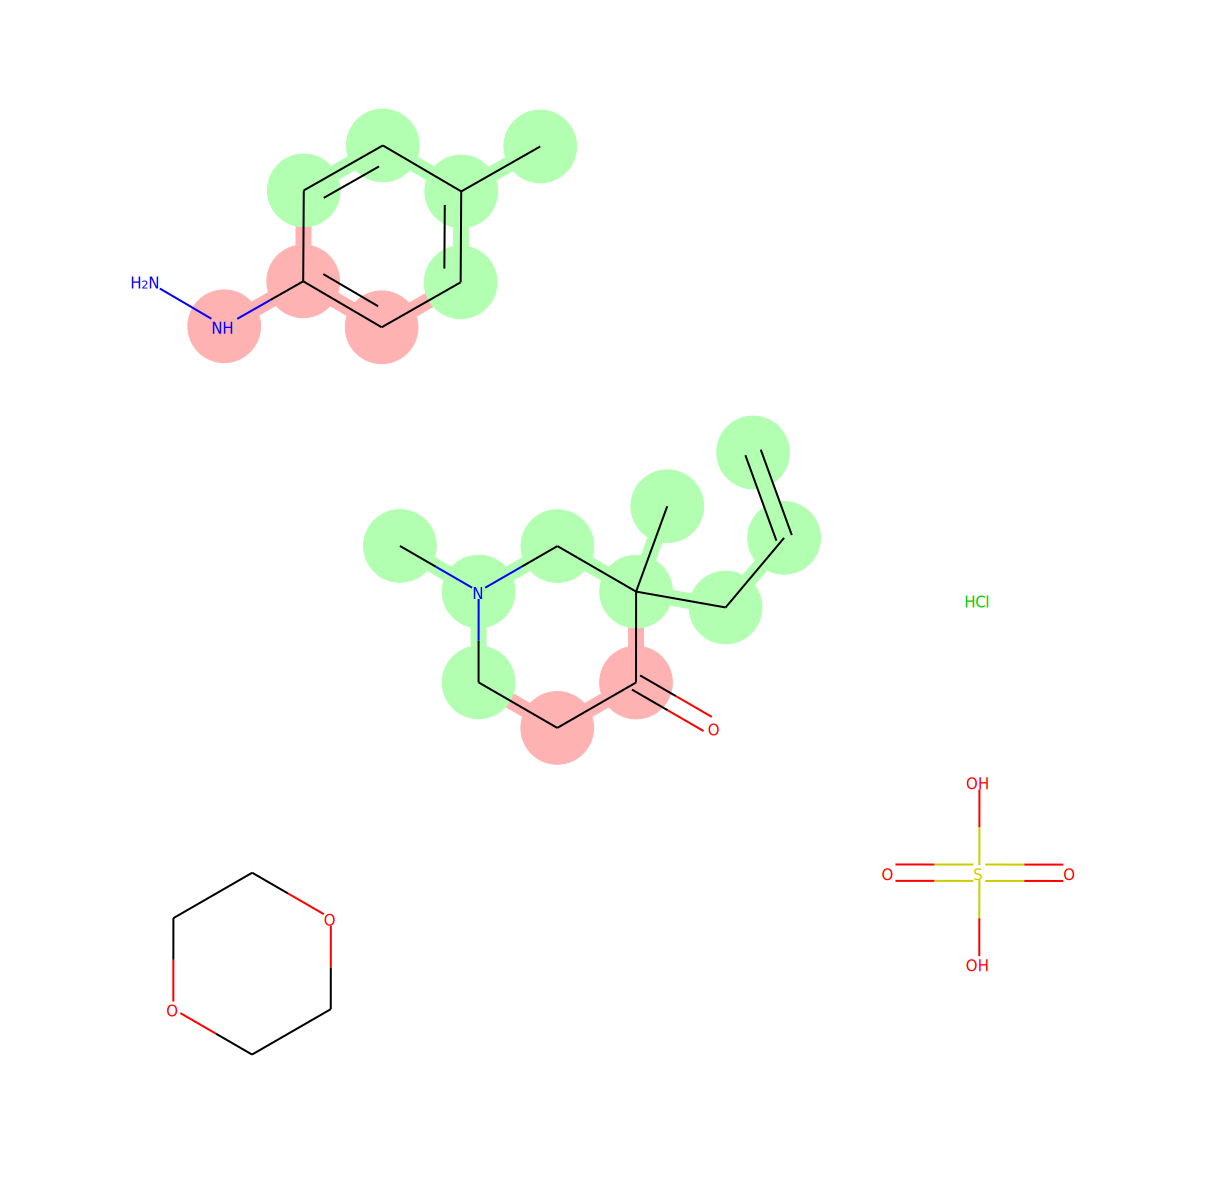

New center
1939
1.9261595


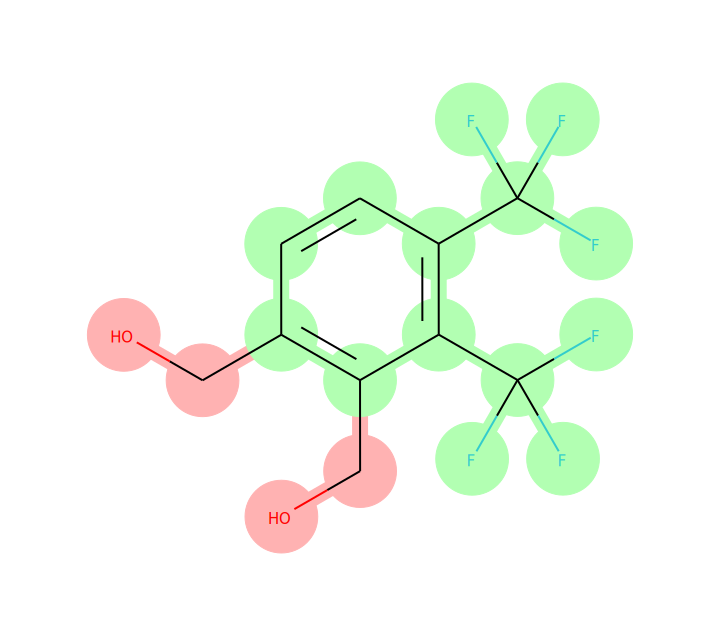

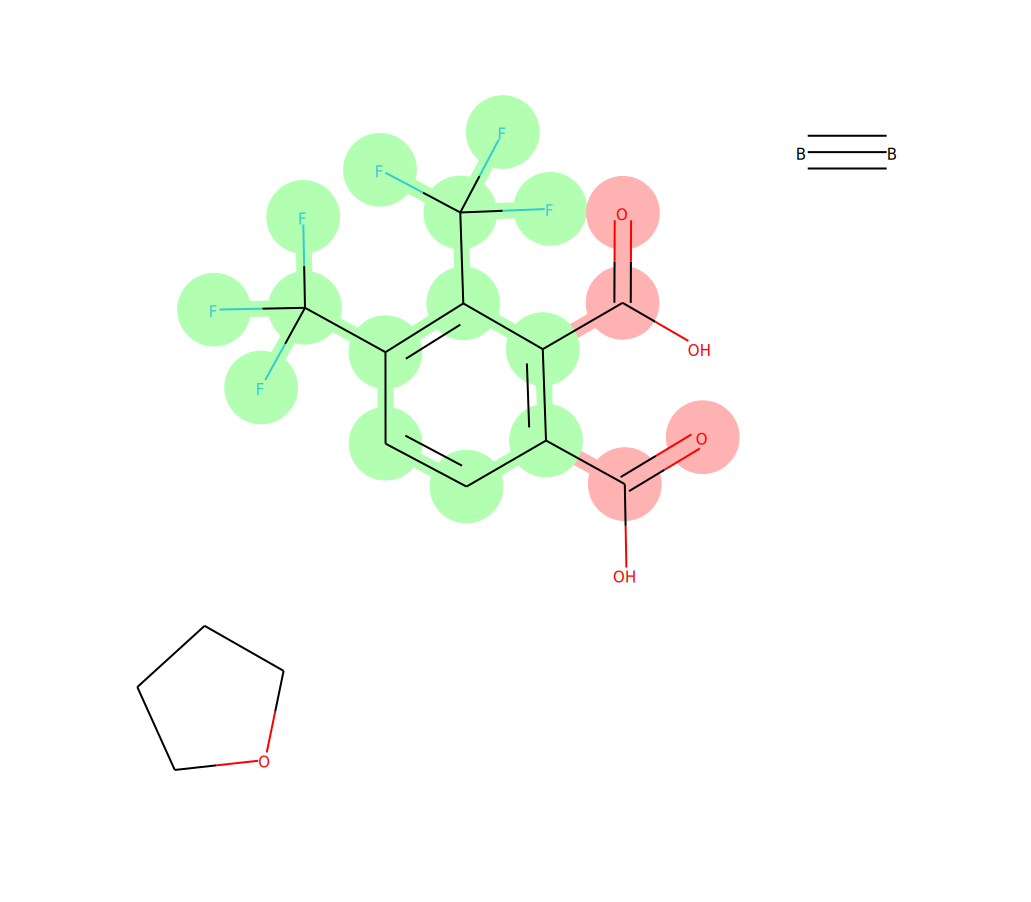

16127
1.9261847


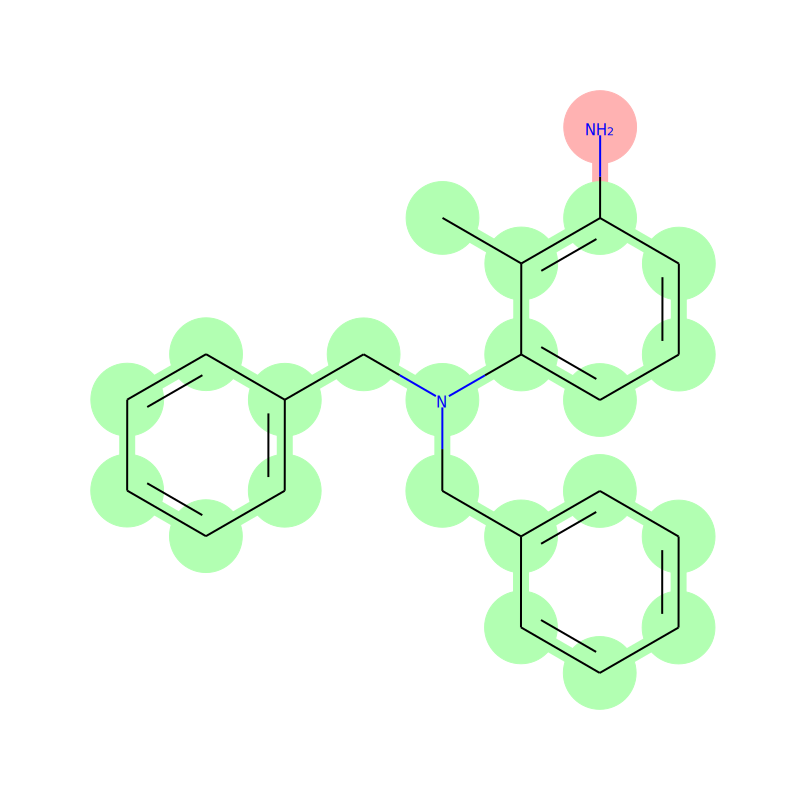

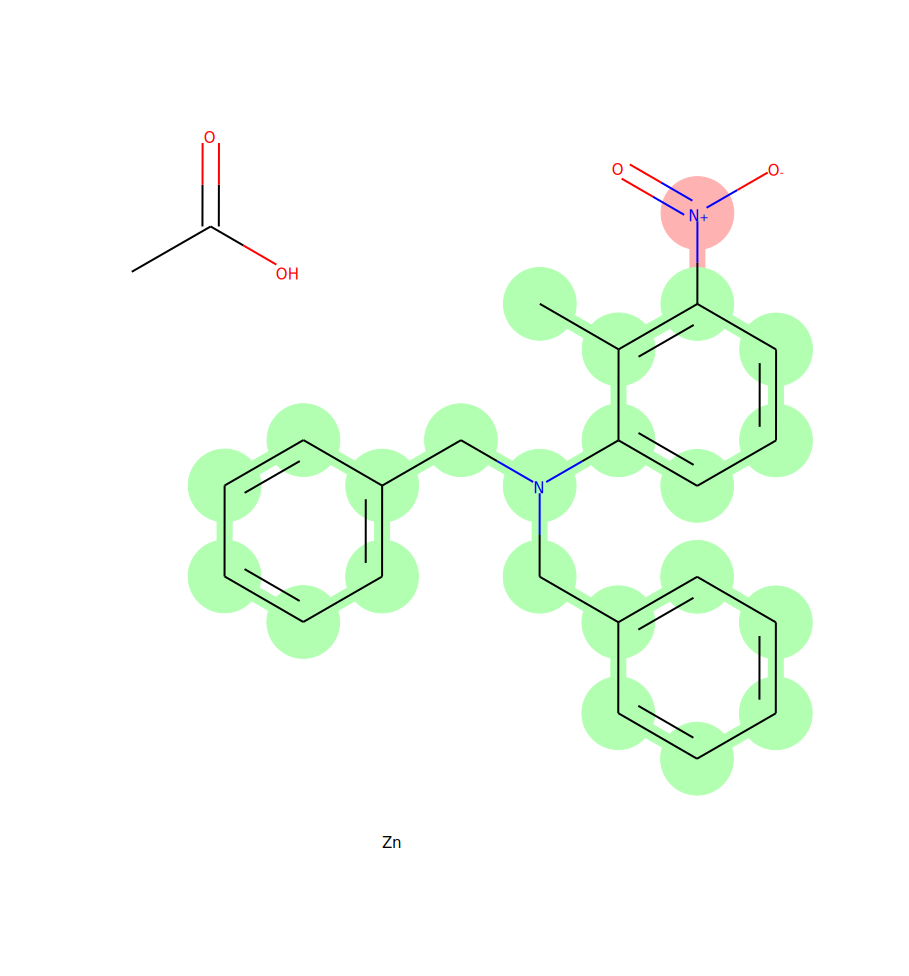

36679
1.9263186


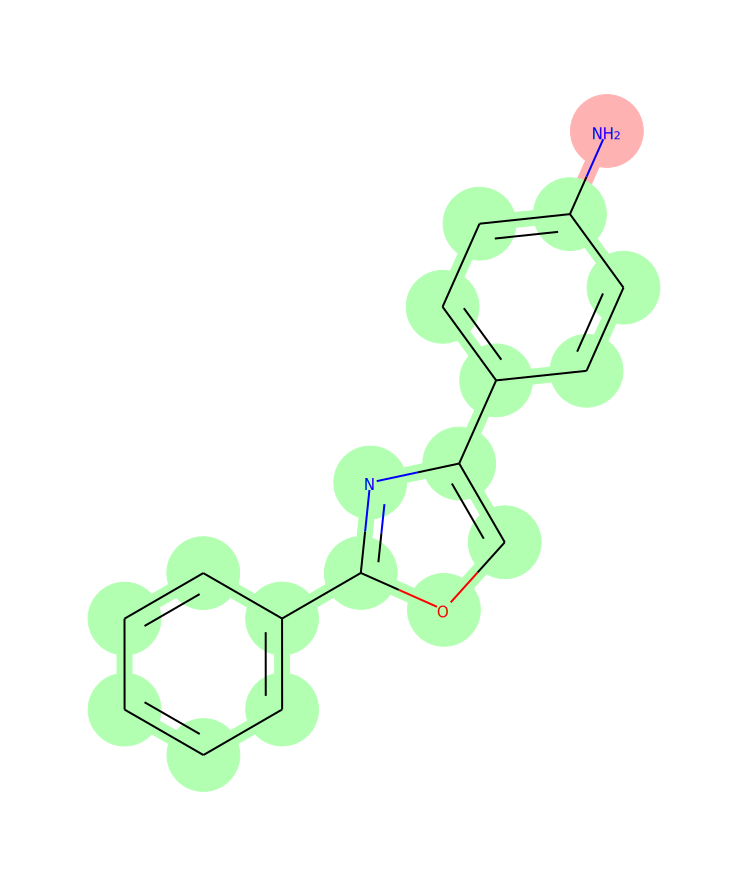

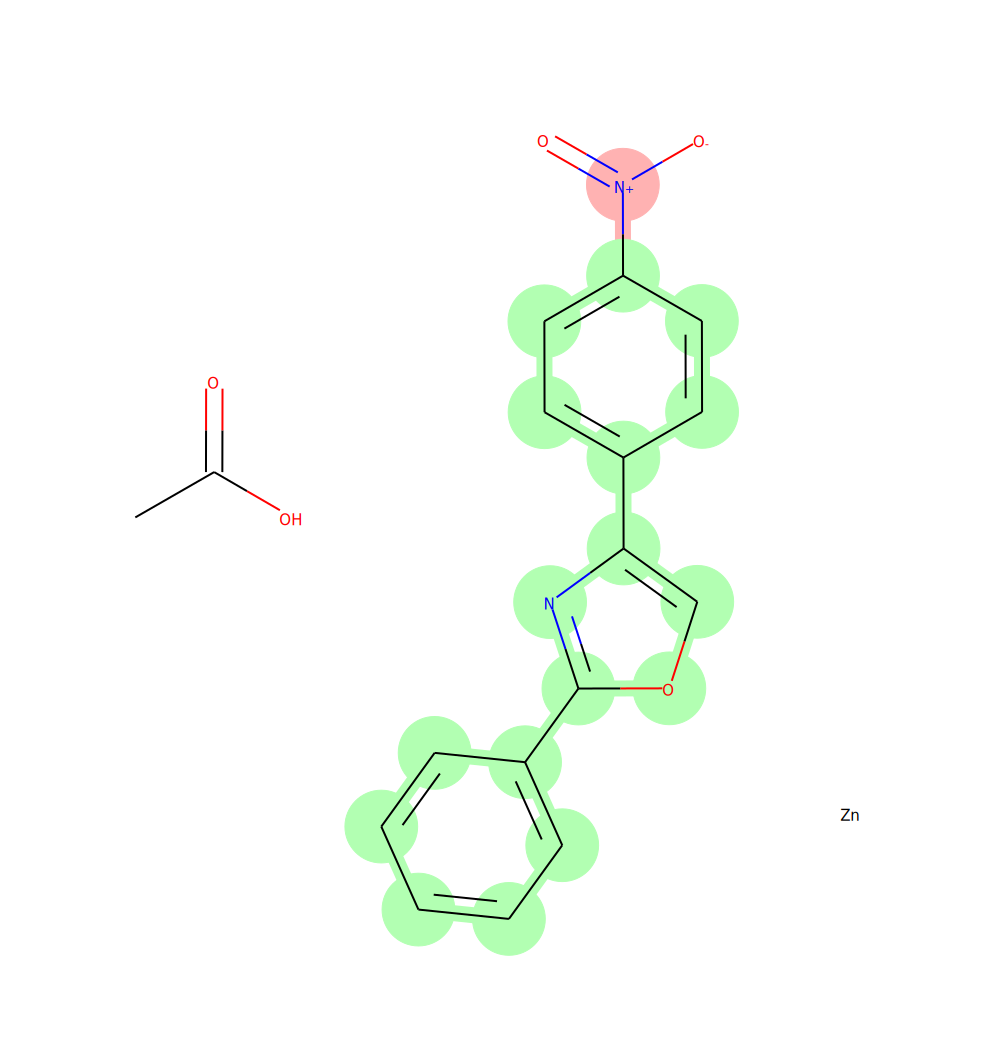

6210
1.9276986


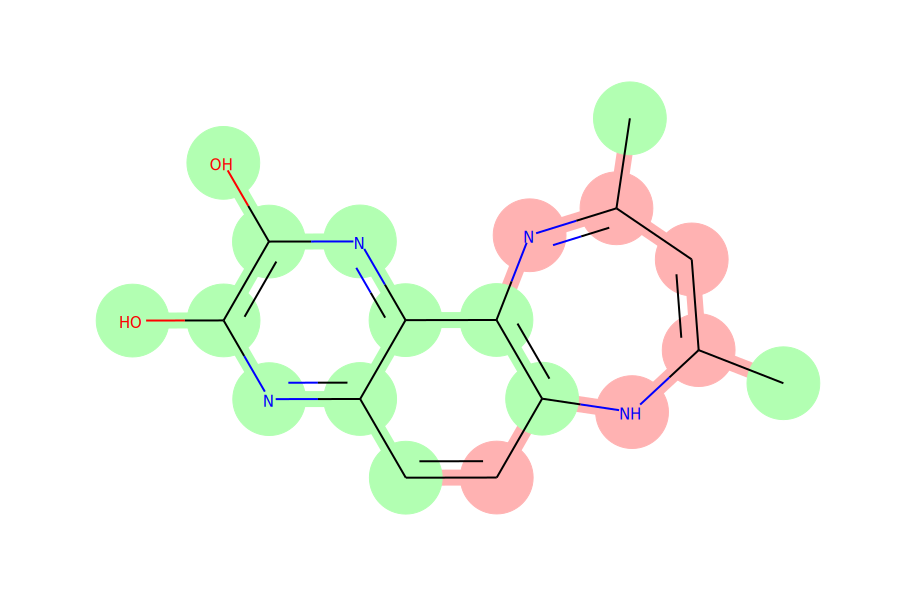

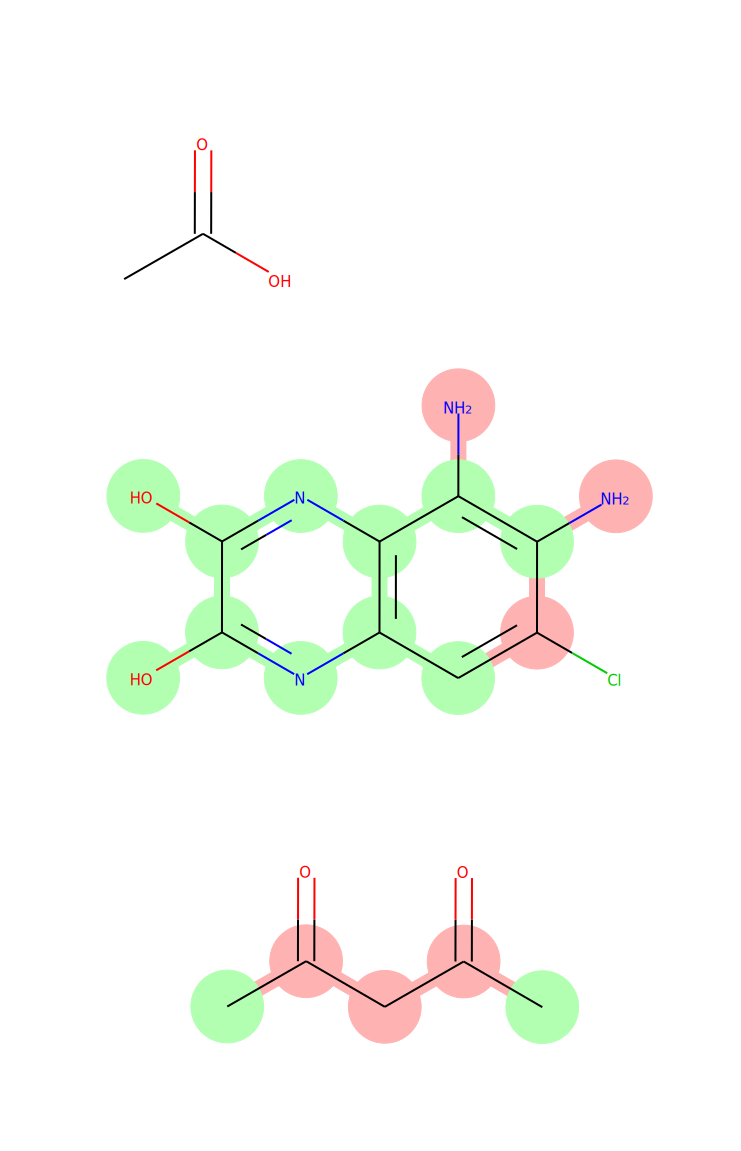

14148
1.9721783


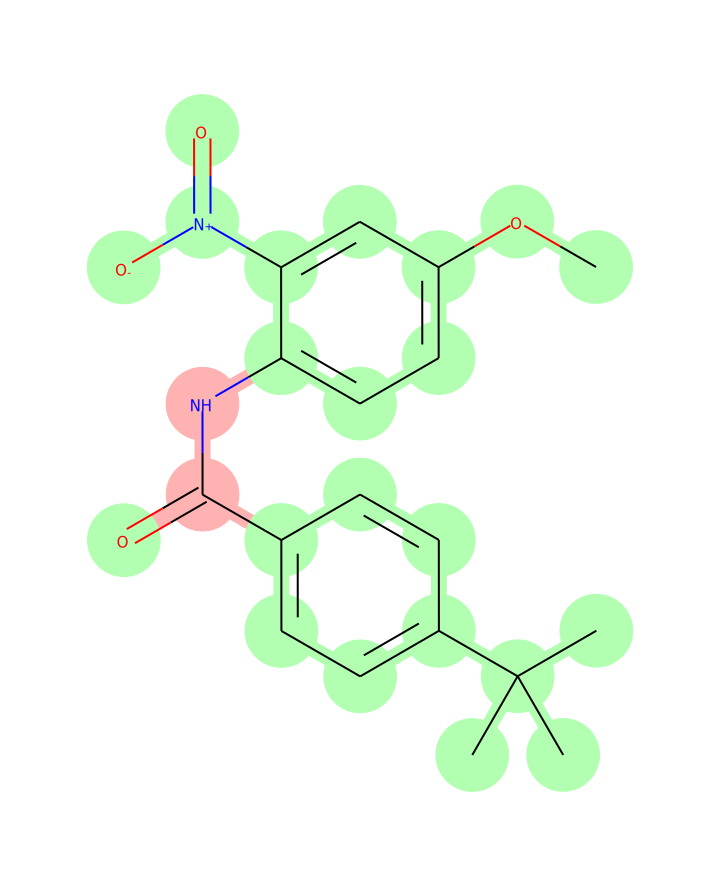

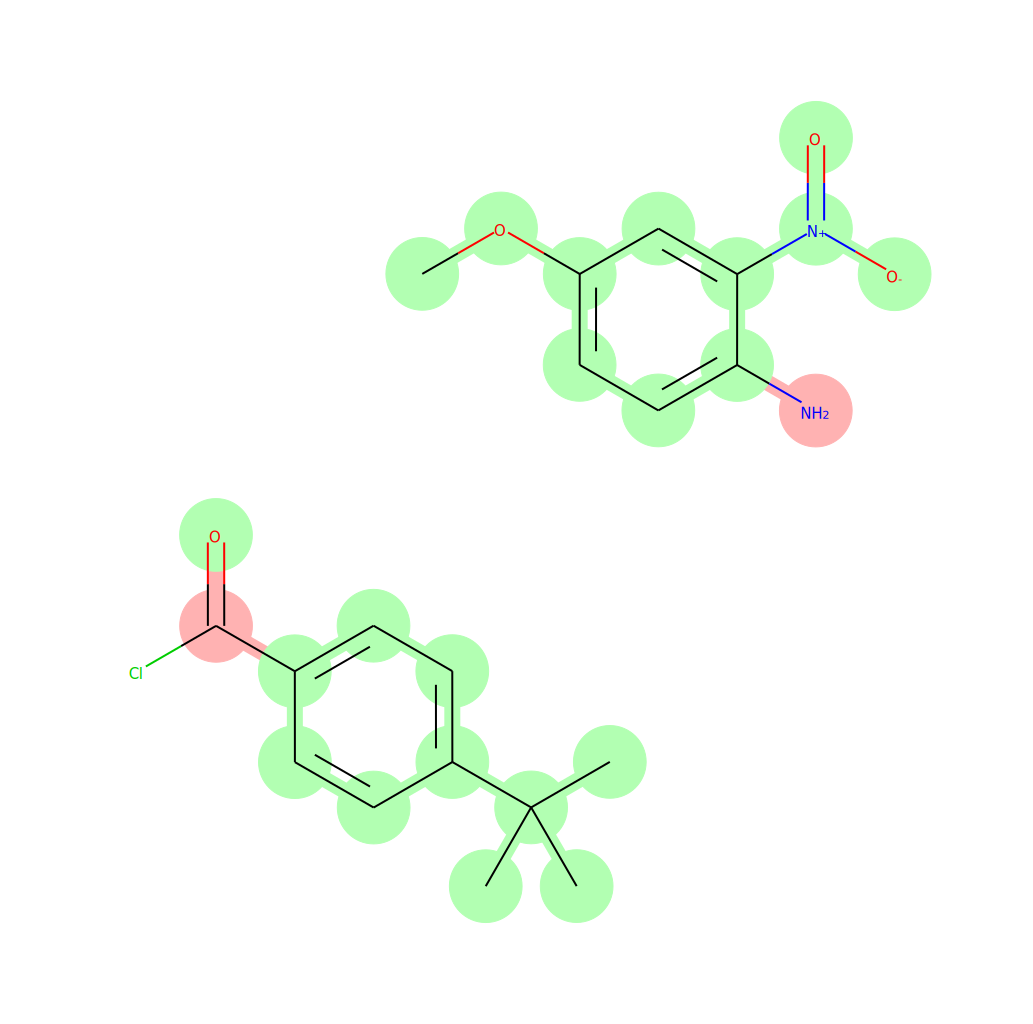

New center
3240
0.036072973


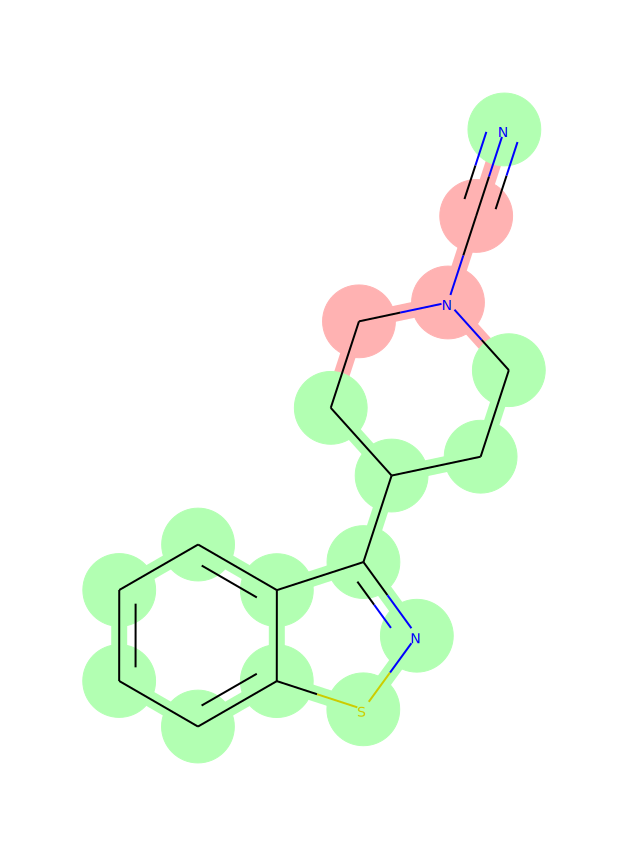

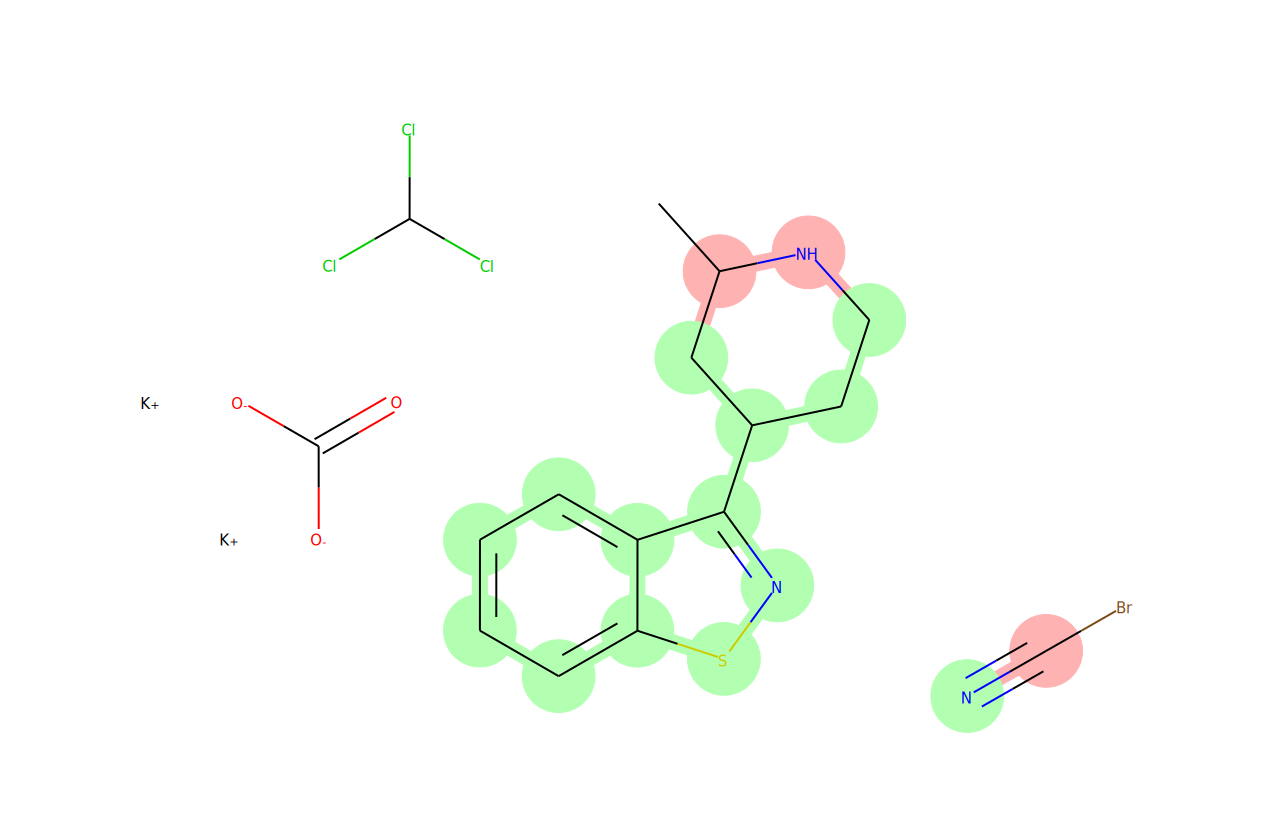

4431
0.03729055


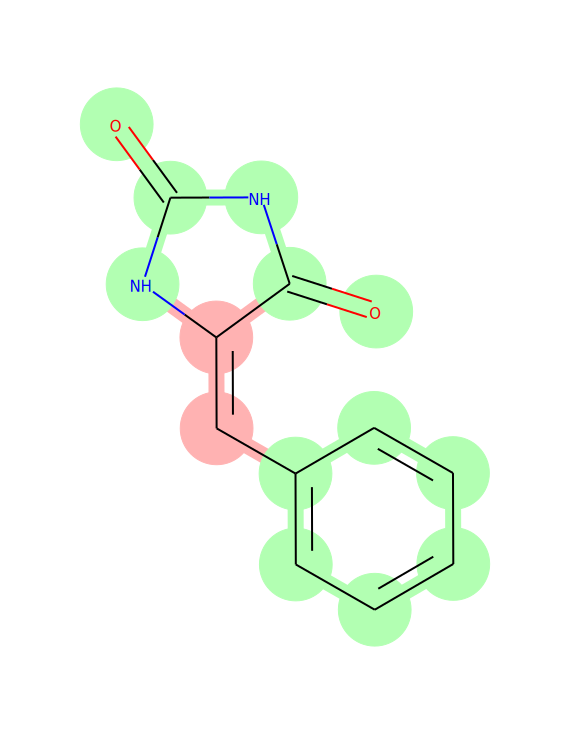

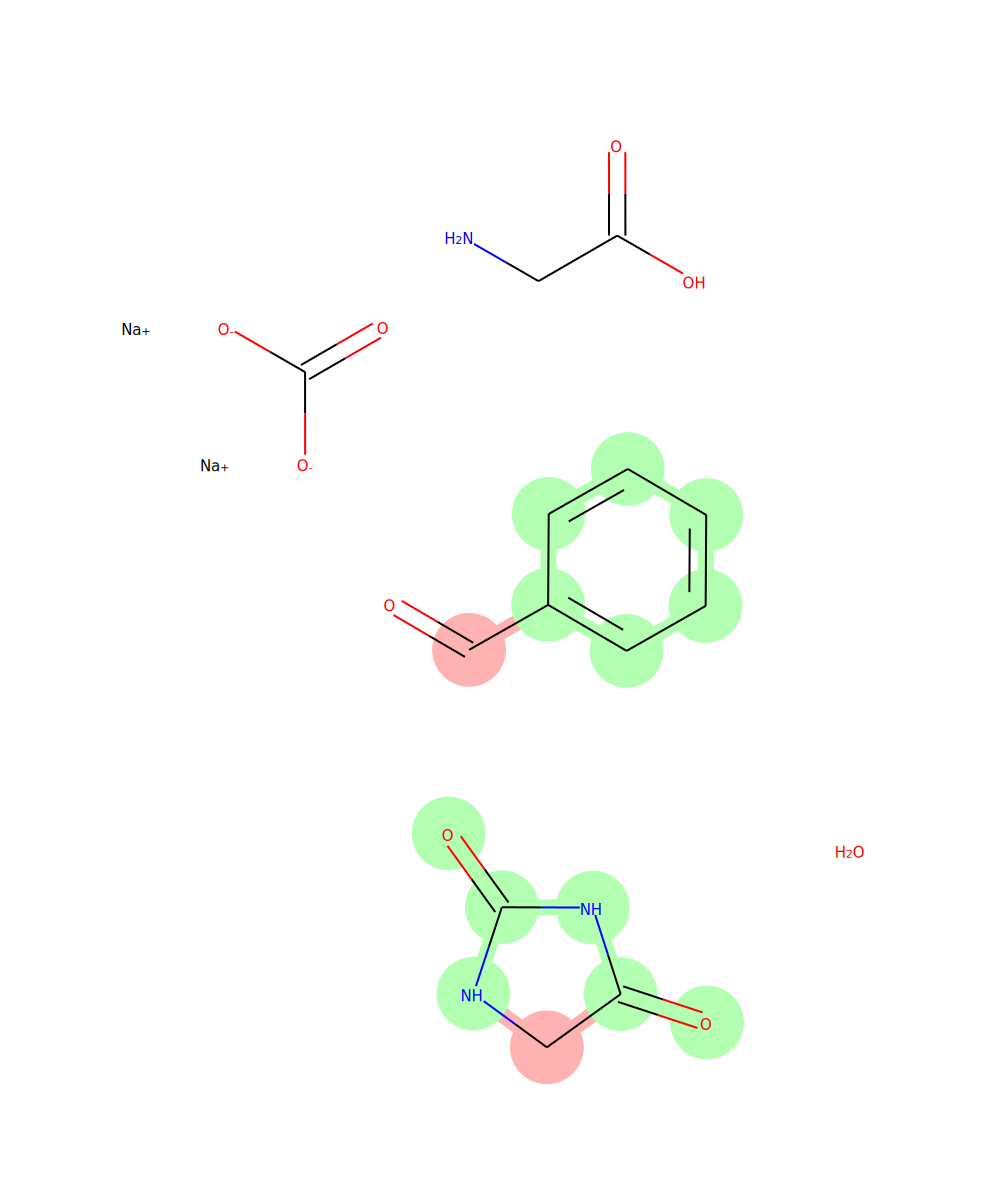

731
0.037664294


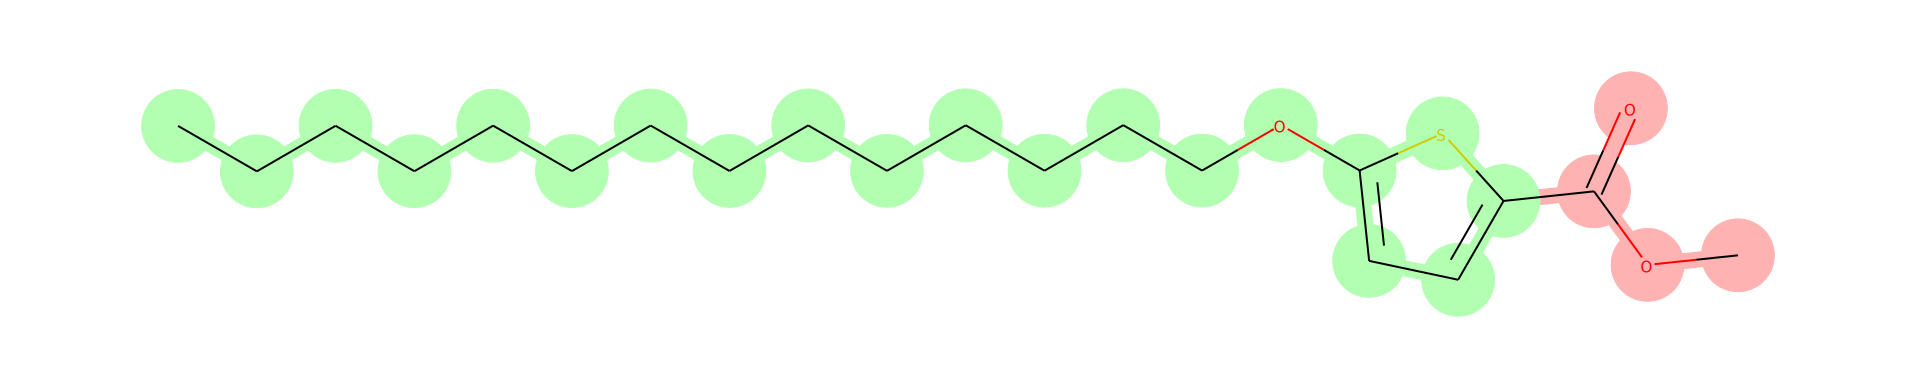

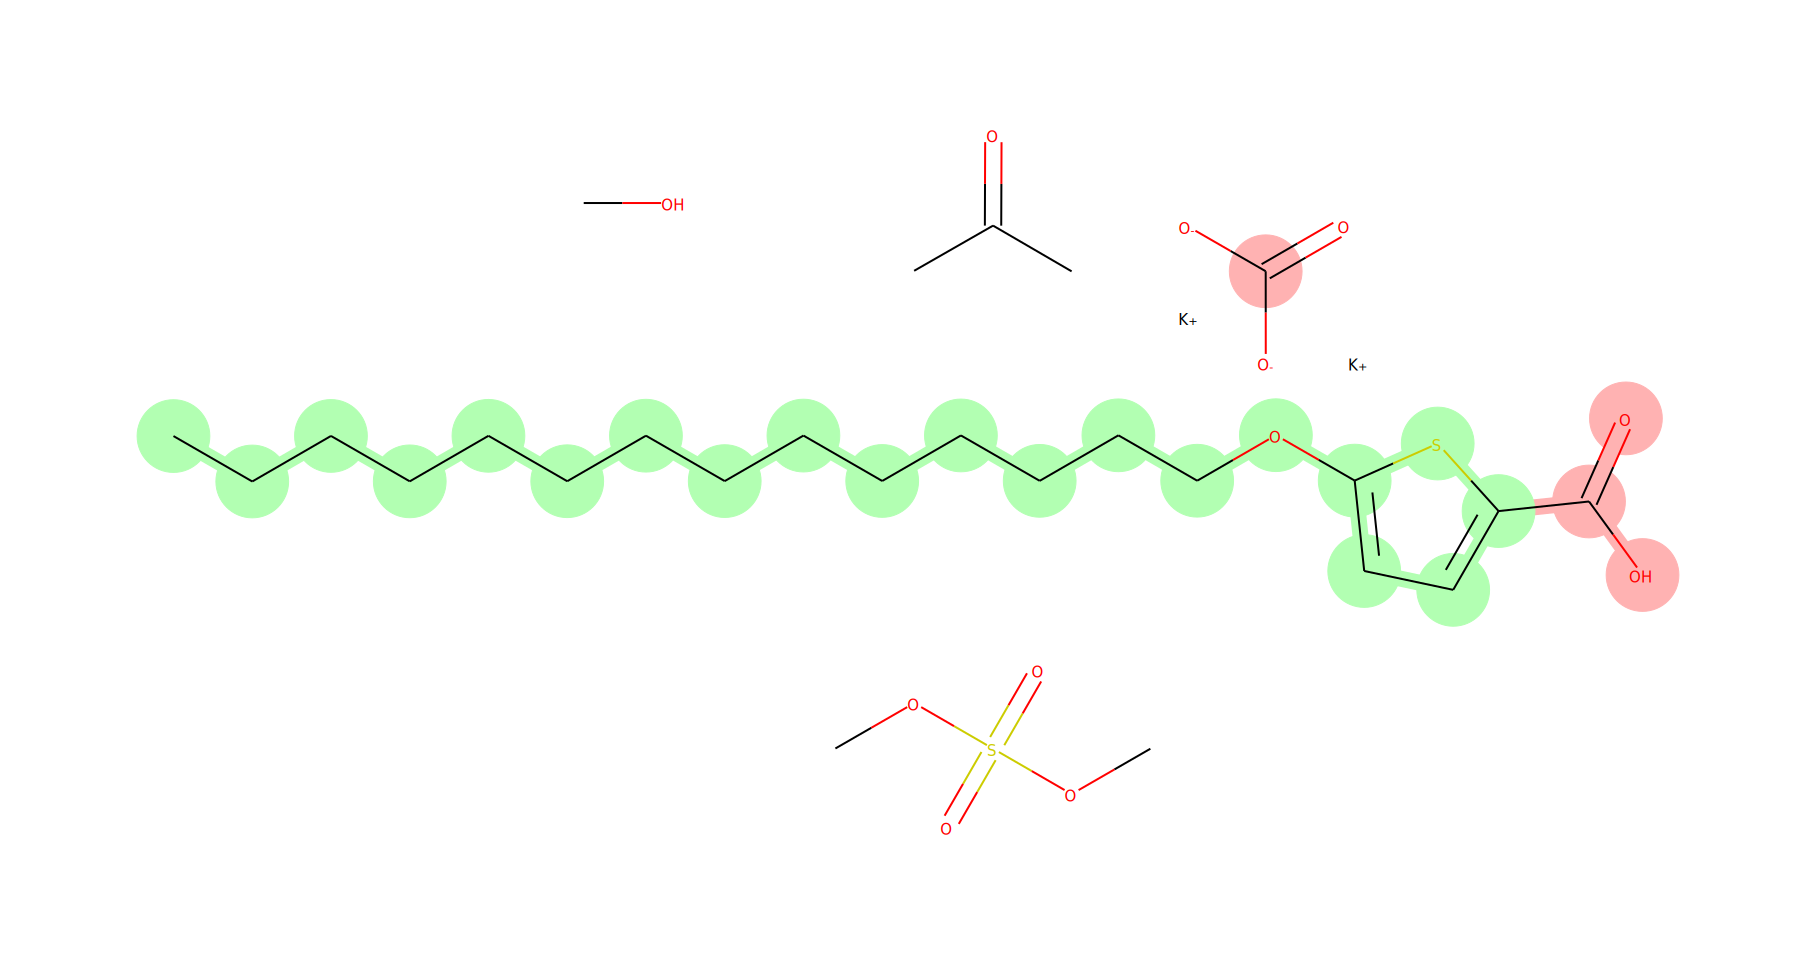

25812
0.04494962


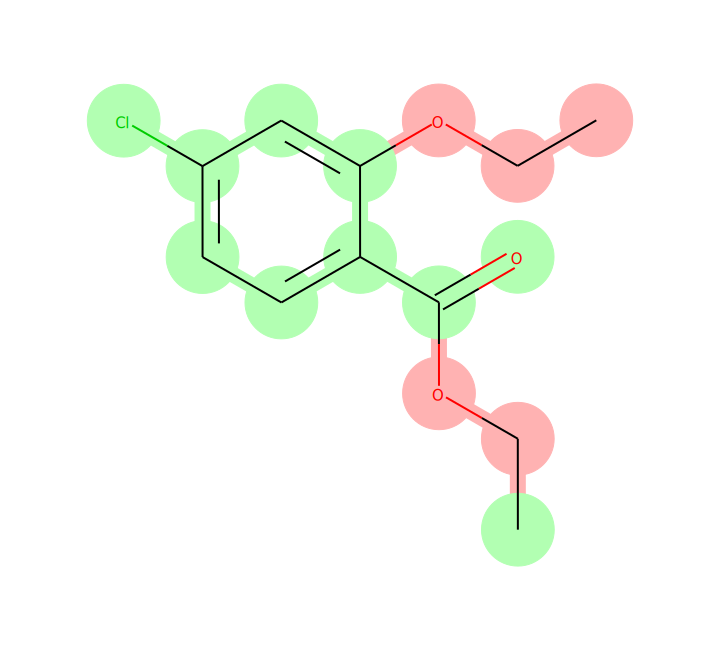

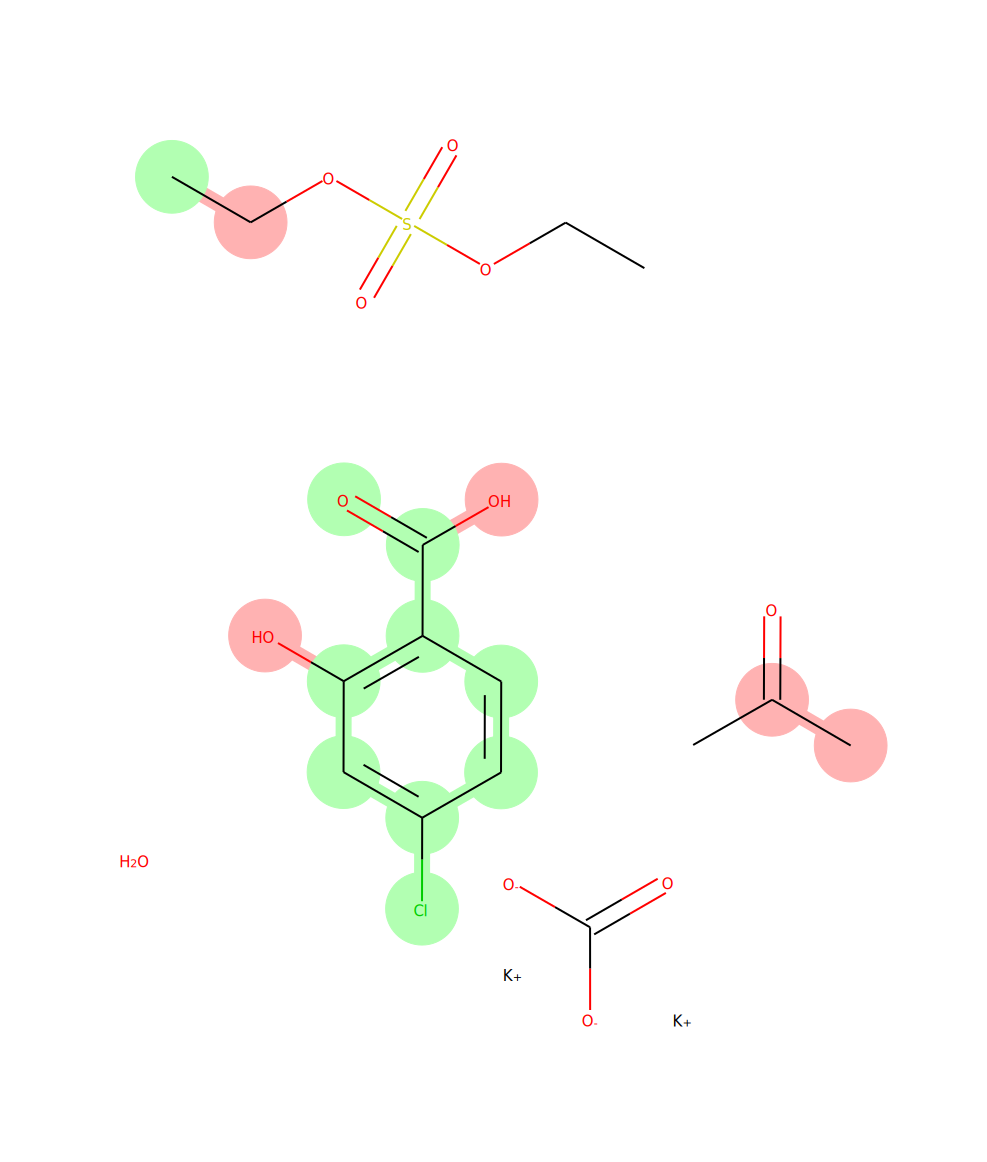

7164
0.19667377


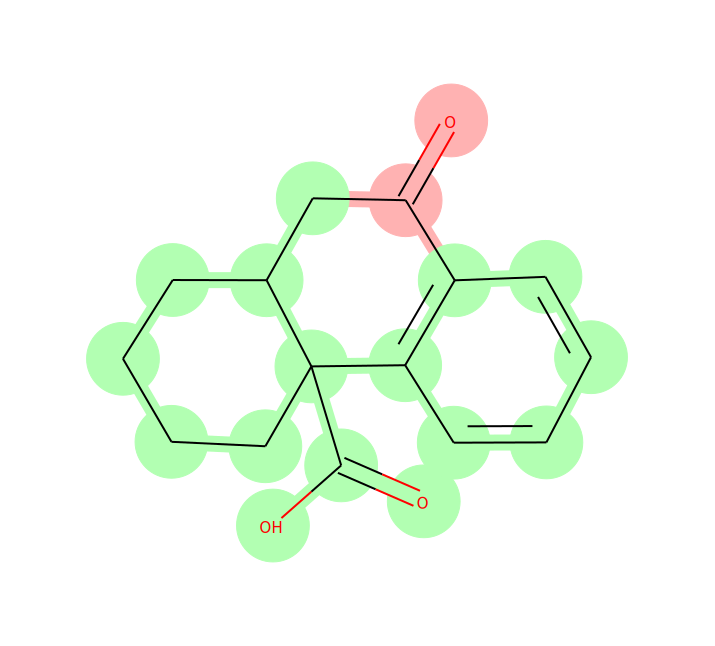

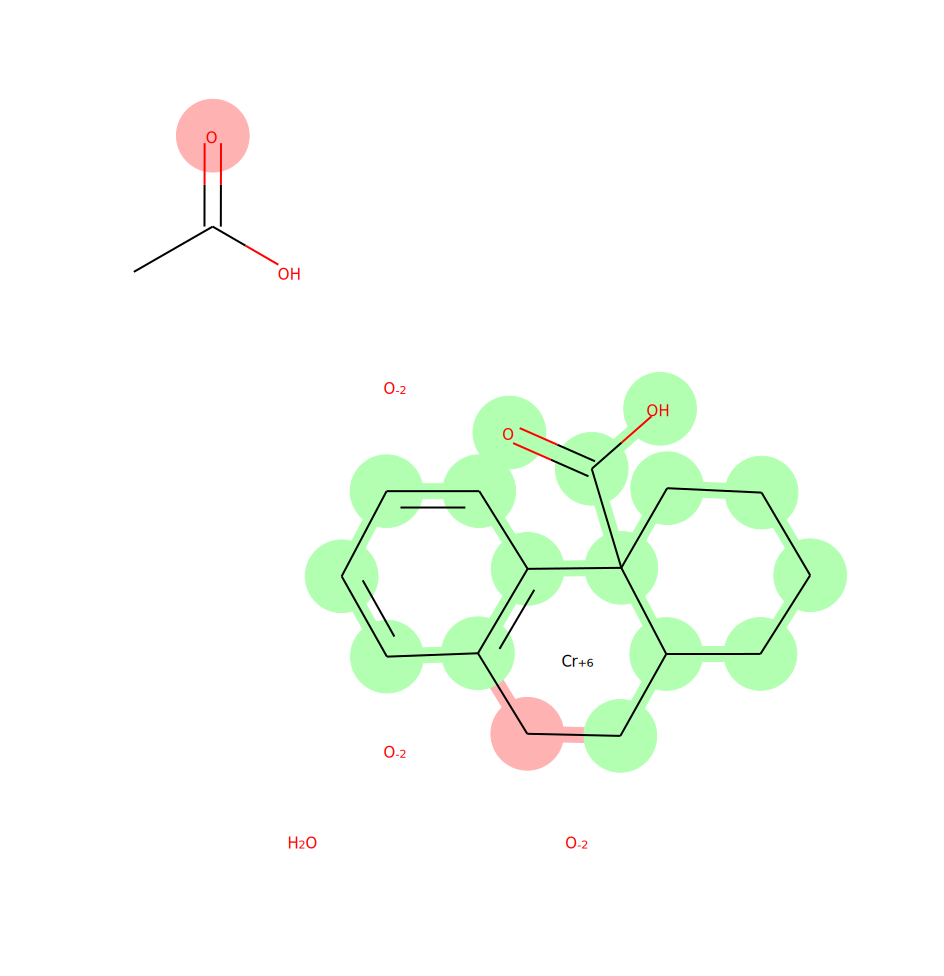

New center
36703
0.6391229


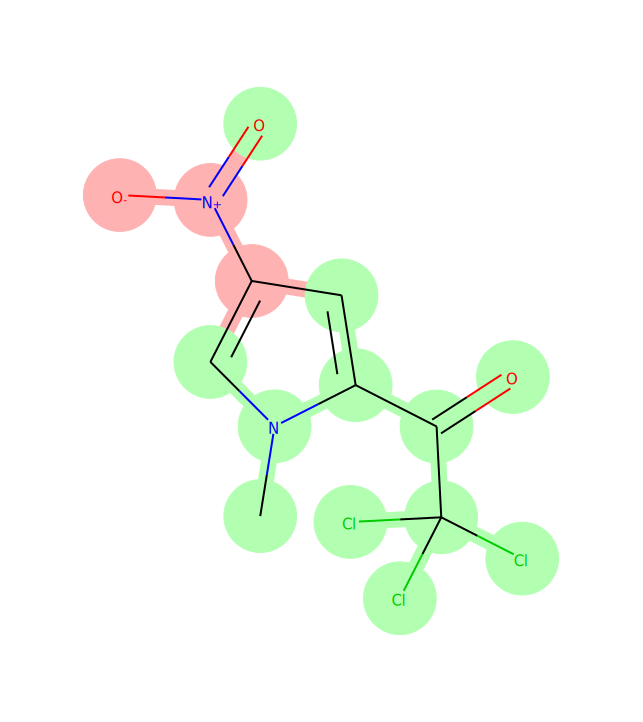

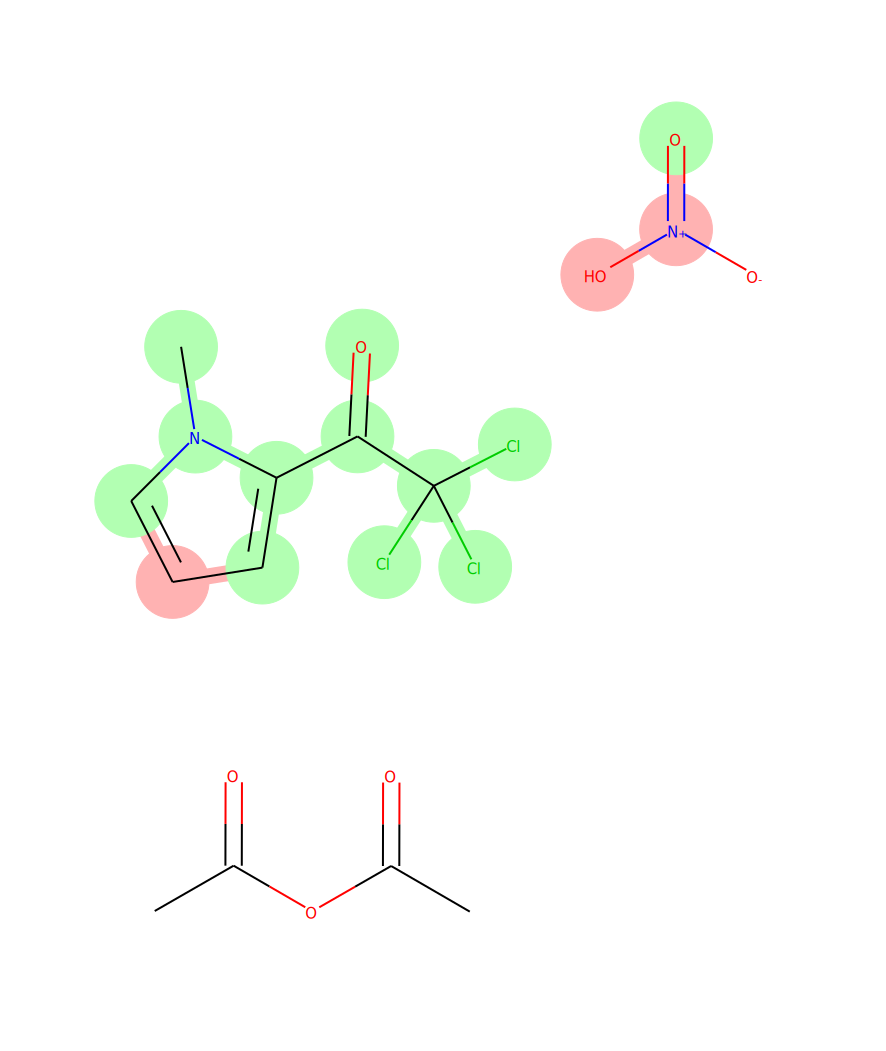

41534
0.6393383


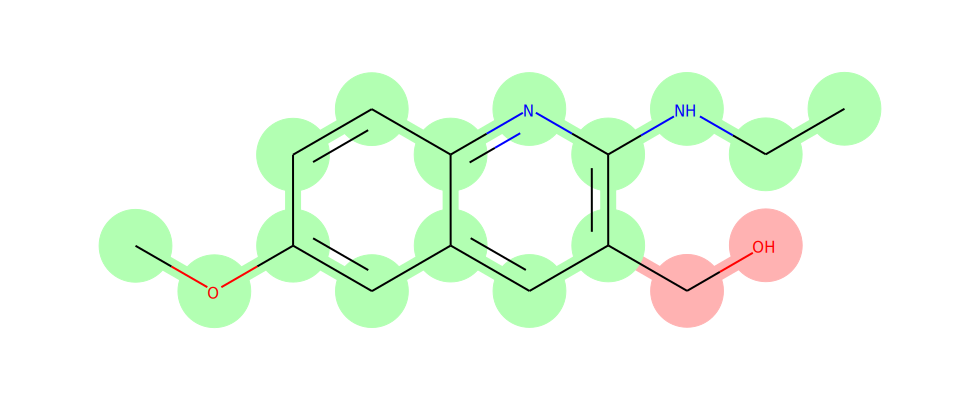

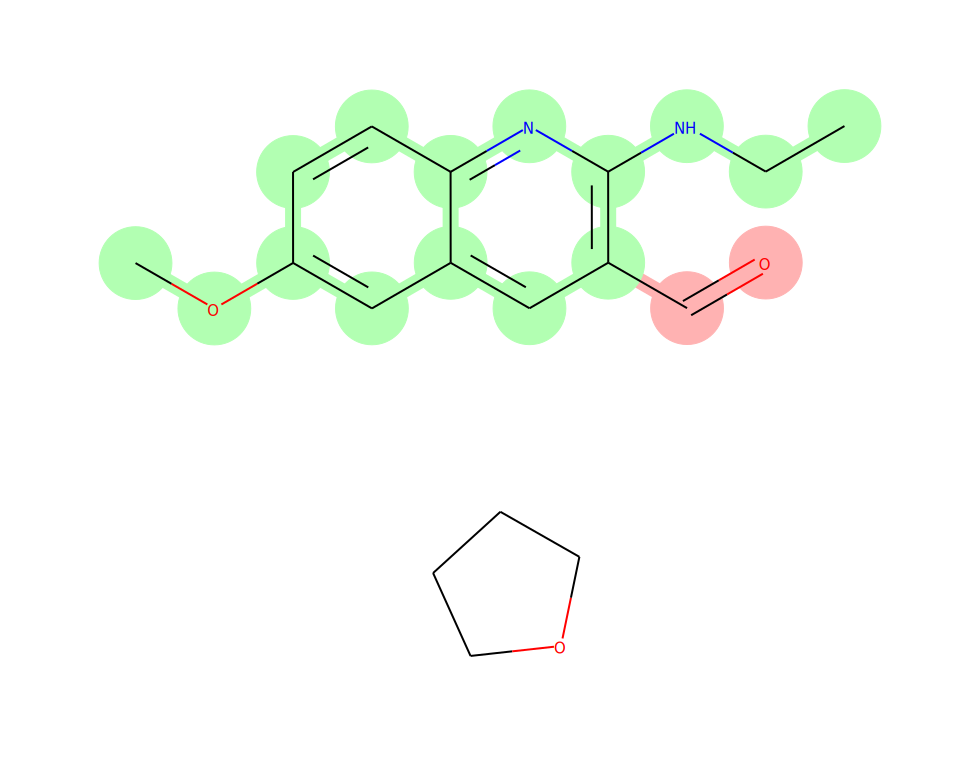

10785
0.6394219


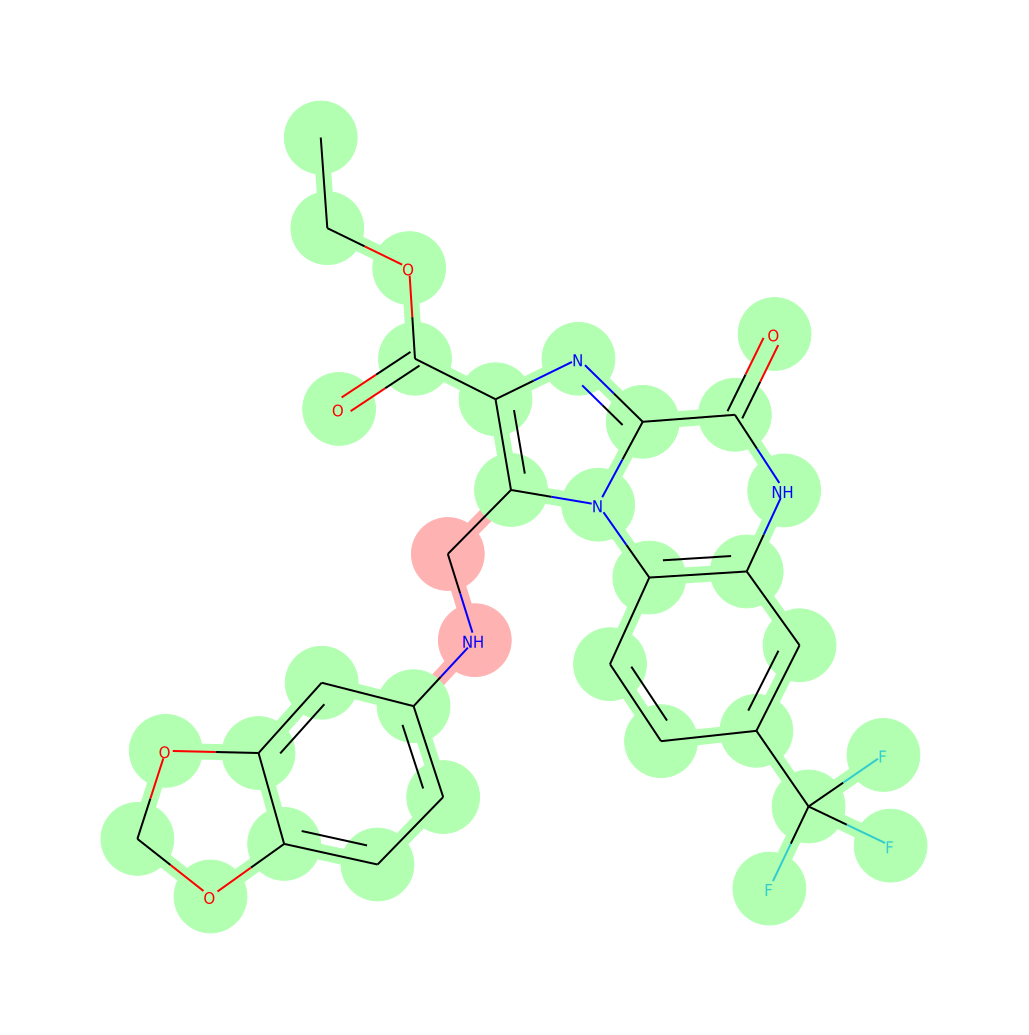

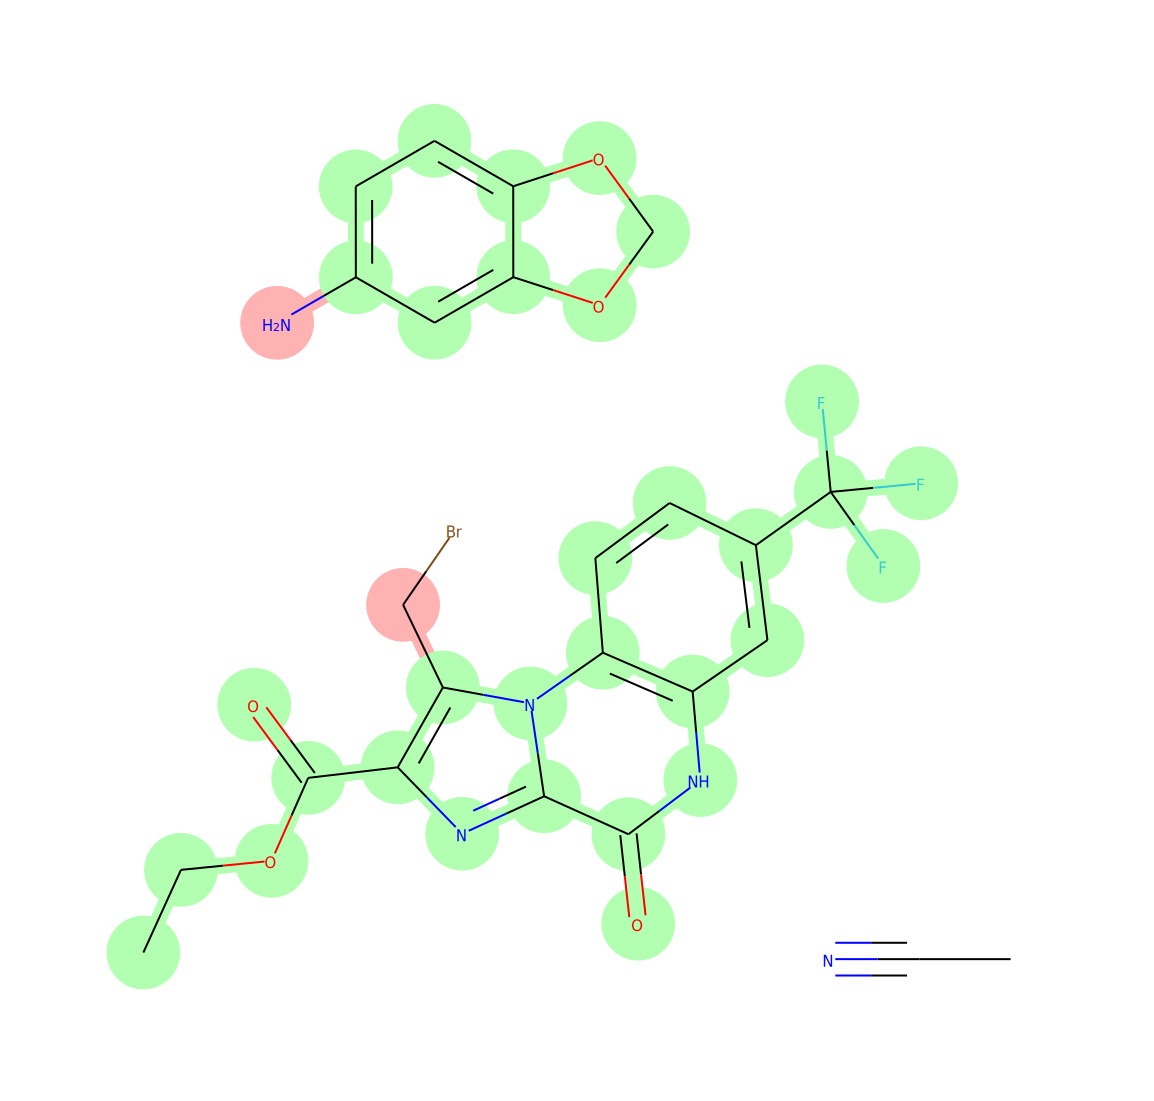

23906
0.64033955


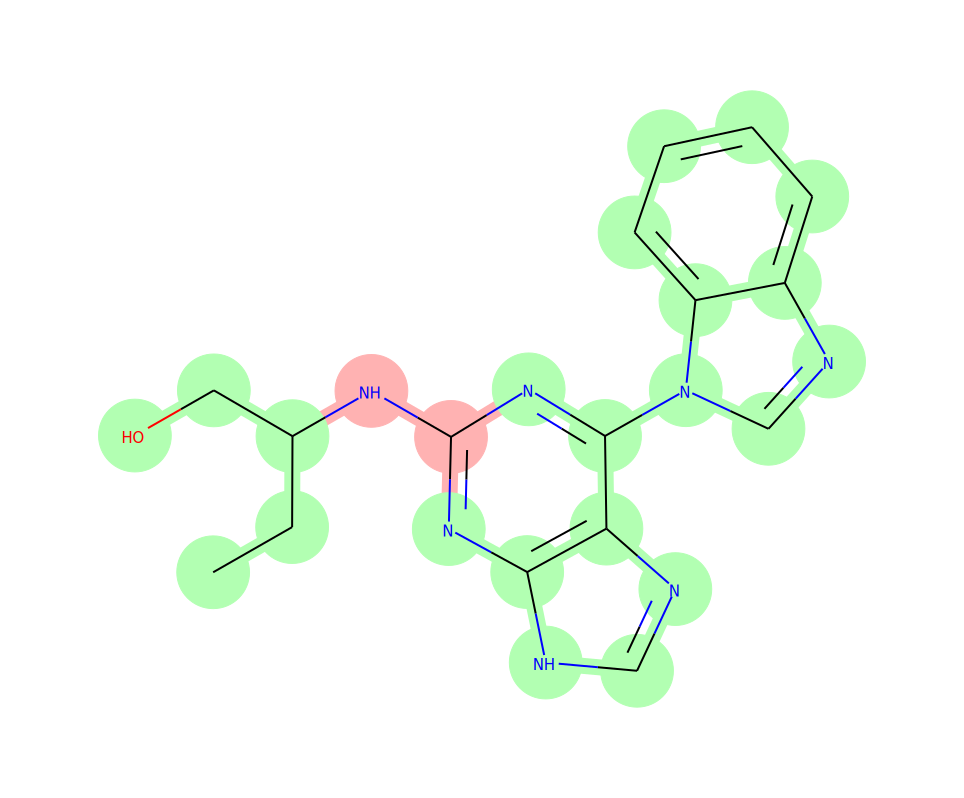

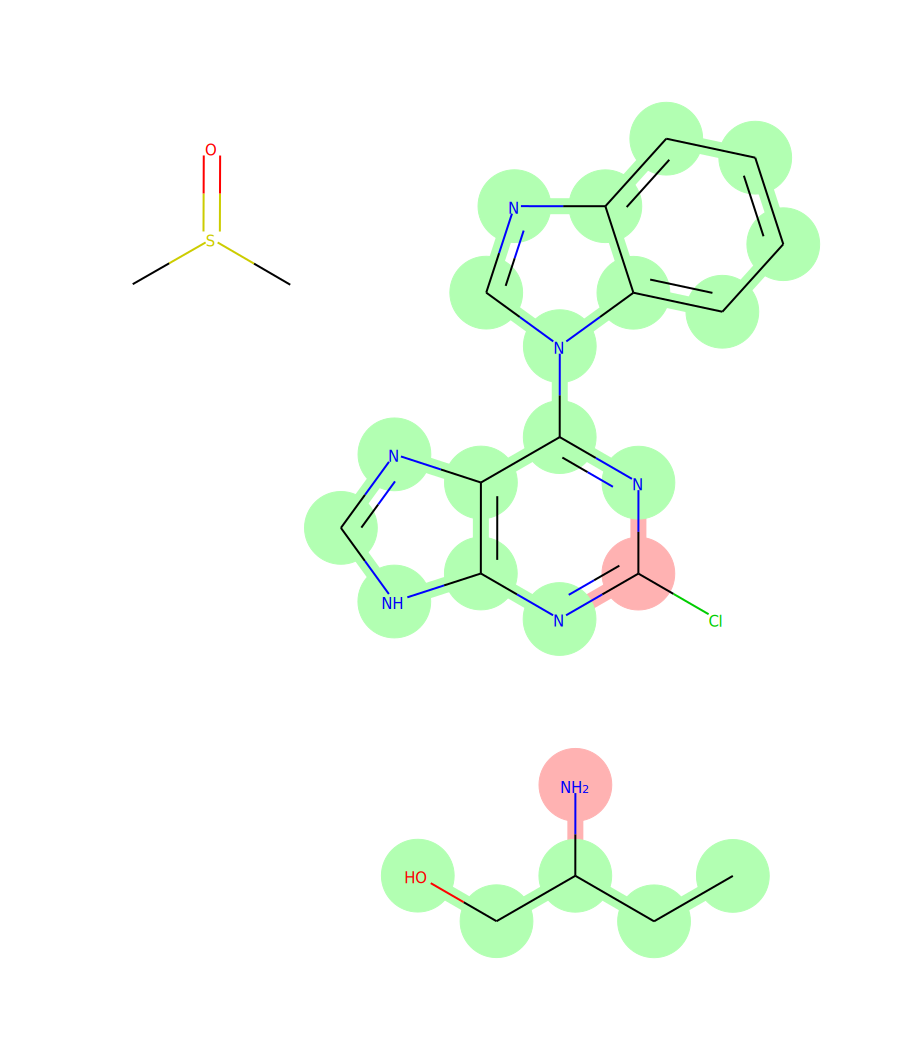

48516
0.66617334


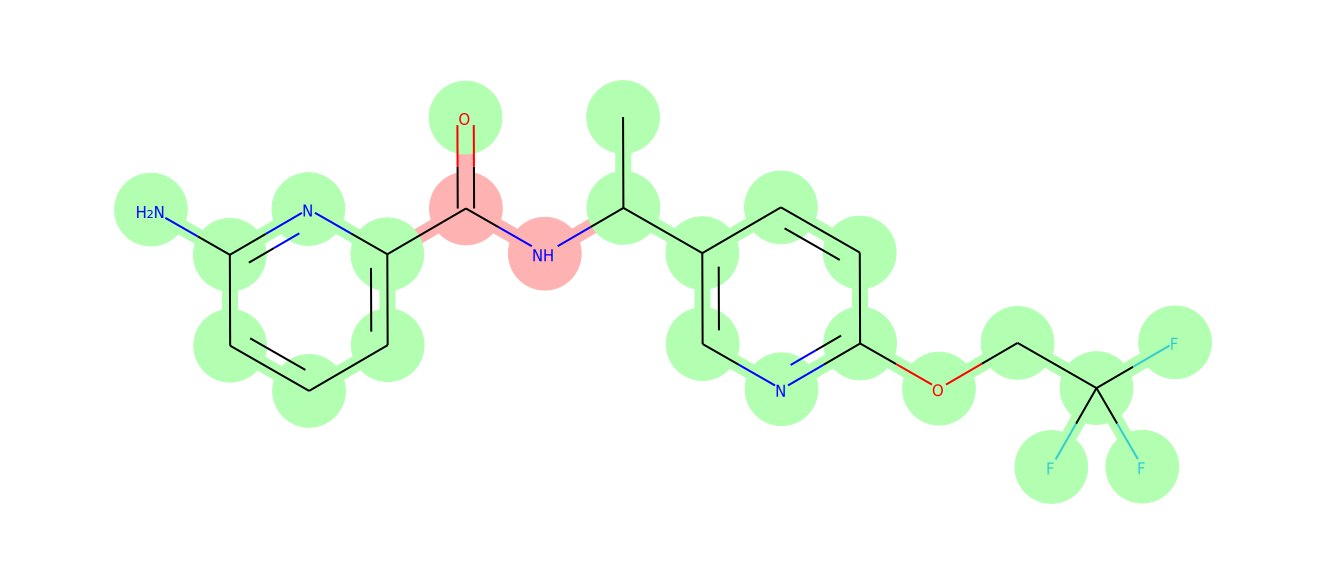

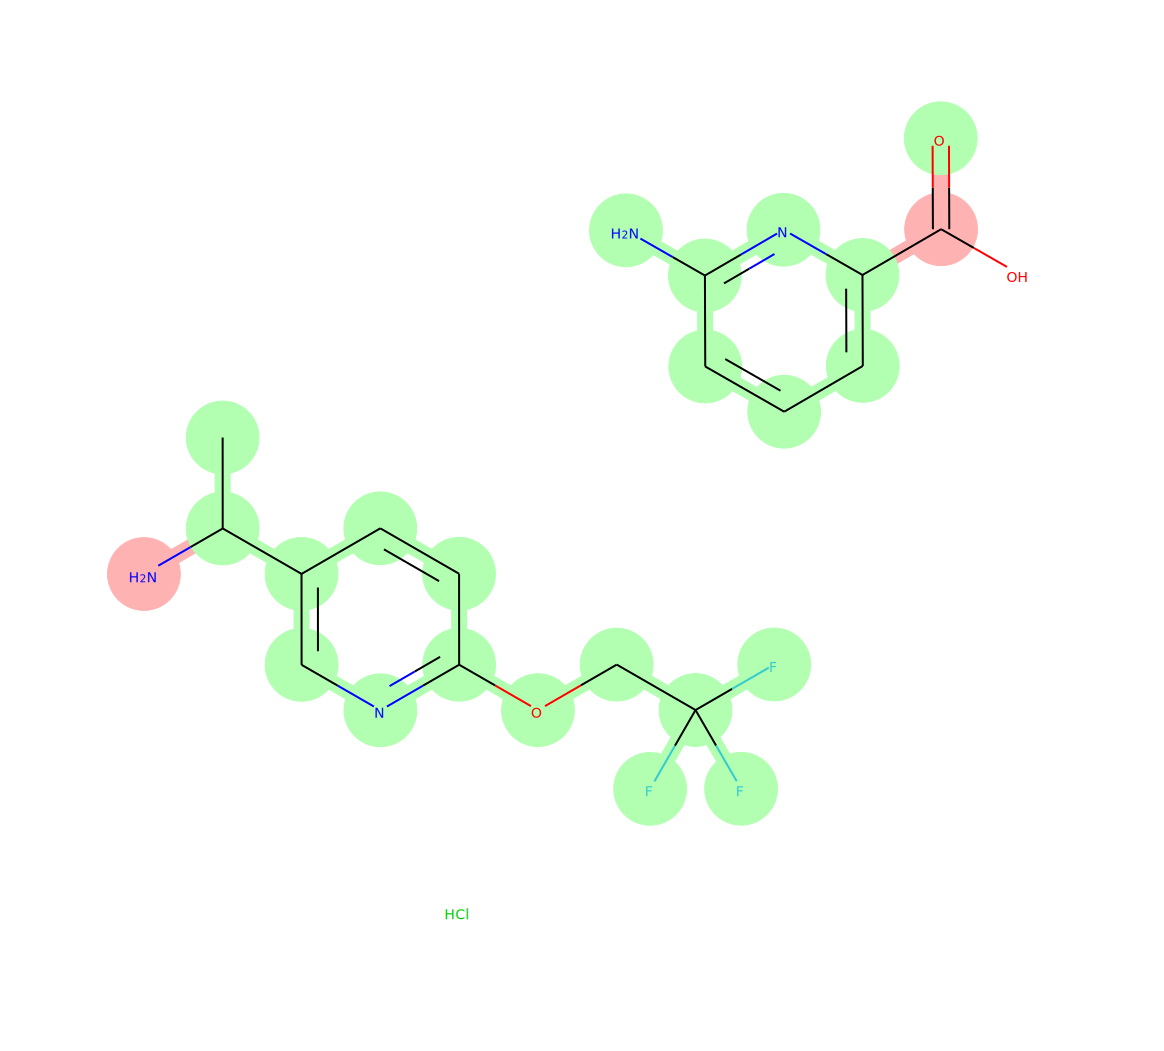

New center
26066
1.1369139


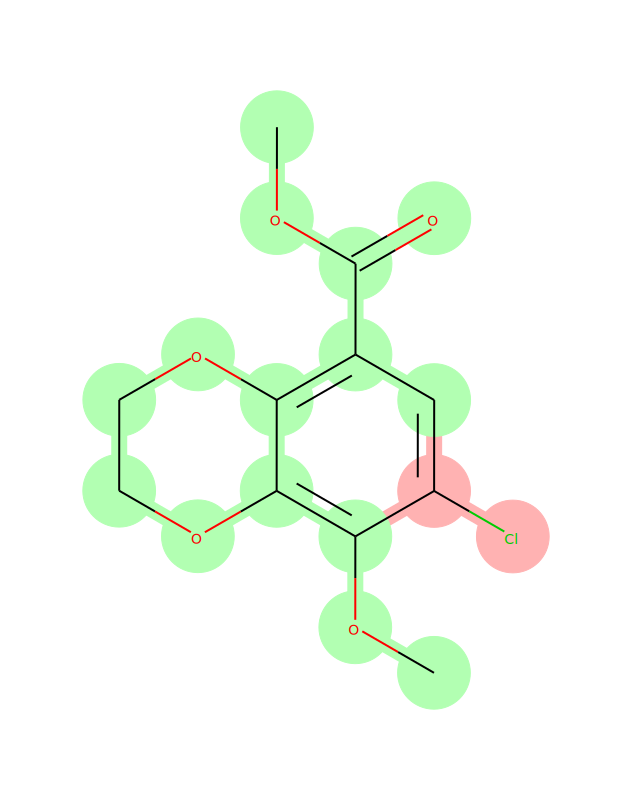

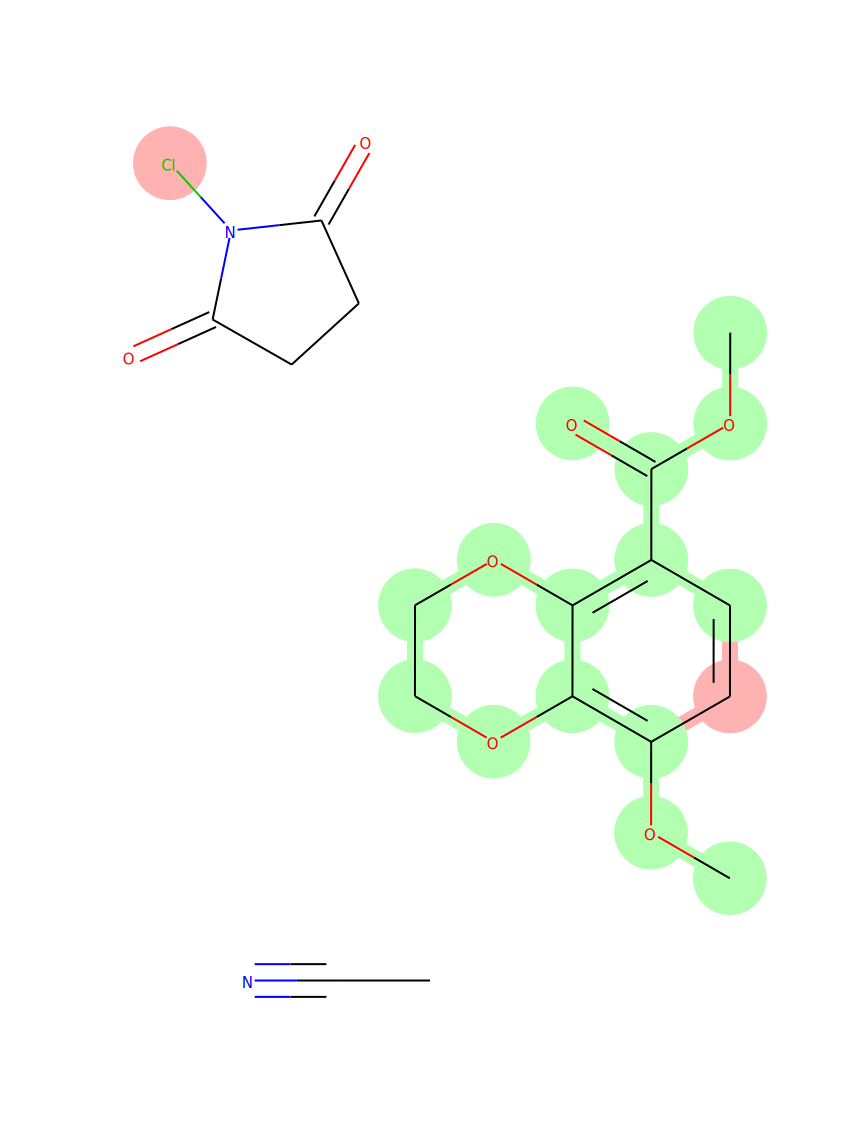

121
1.1369457


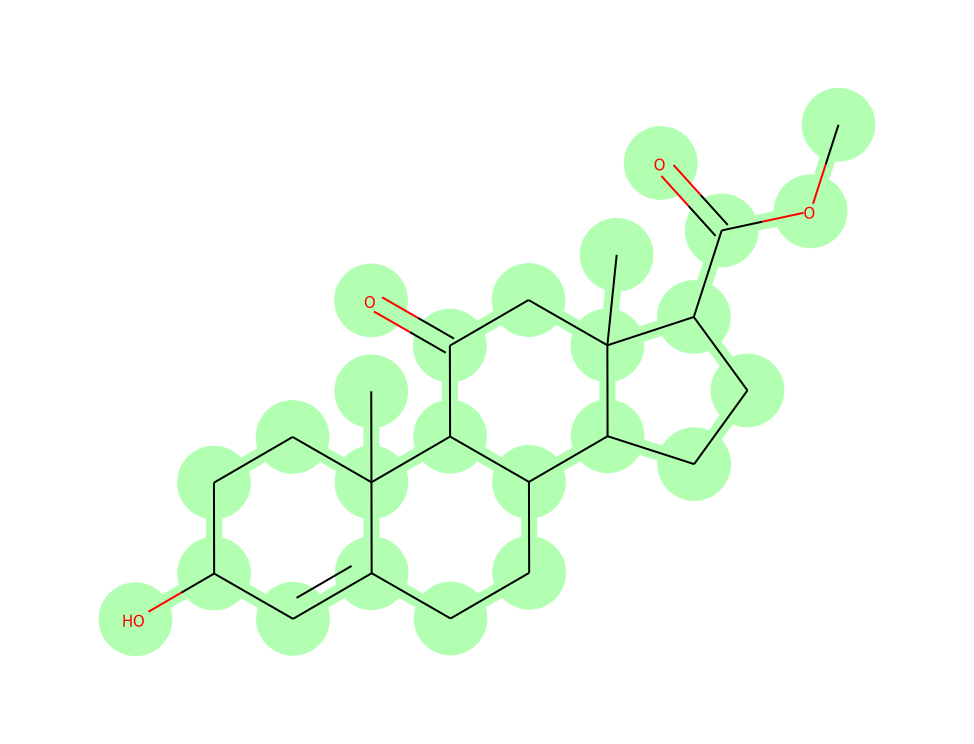

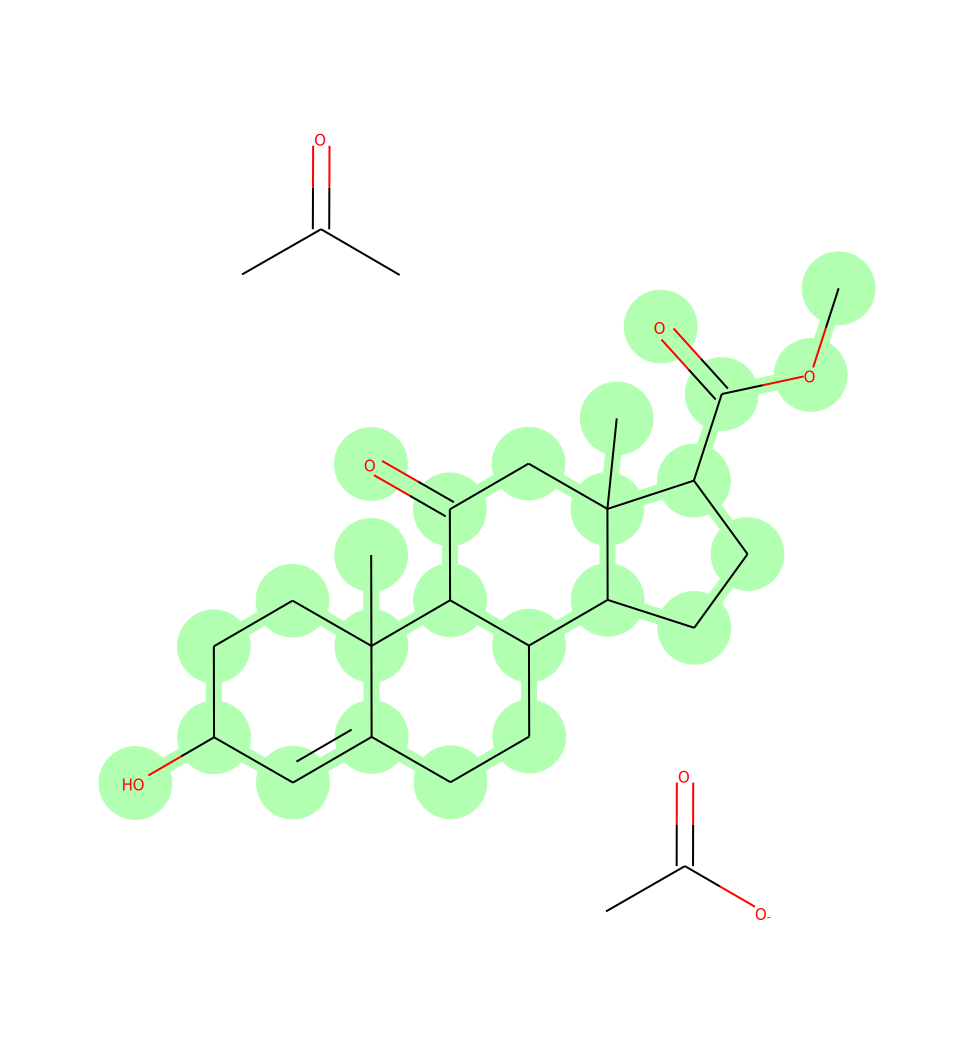

19946
1.1369928


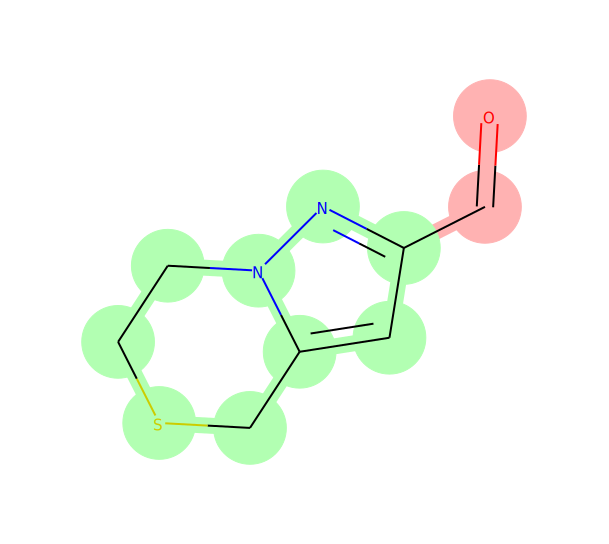

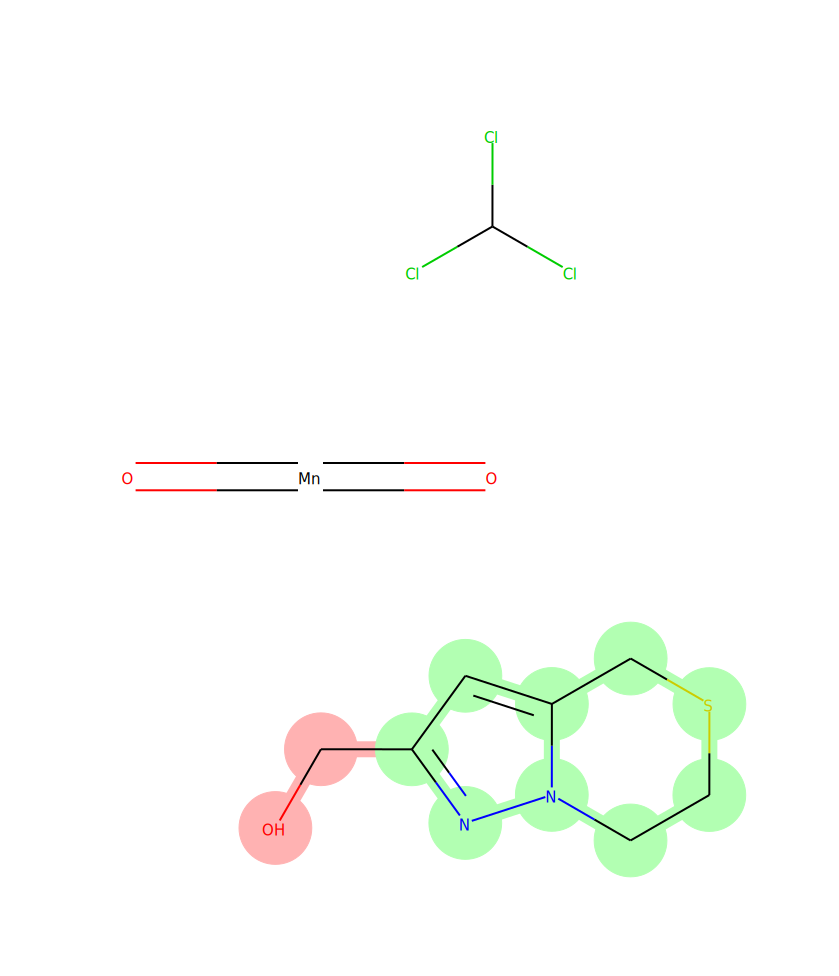

31333
1.1377262


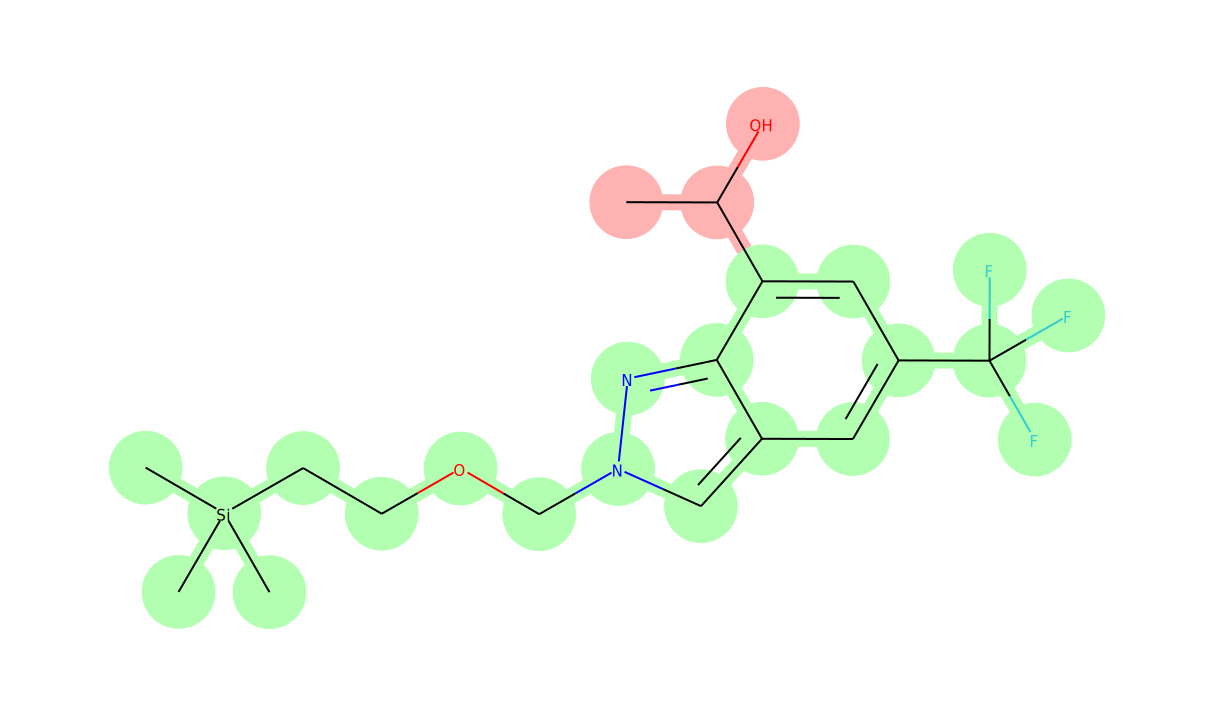

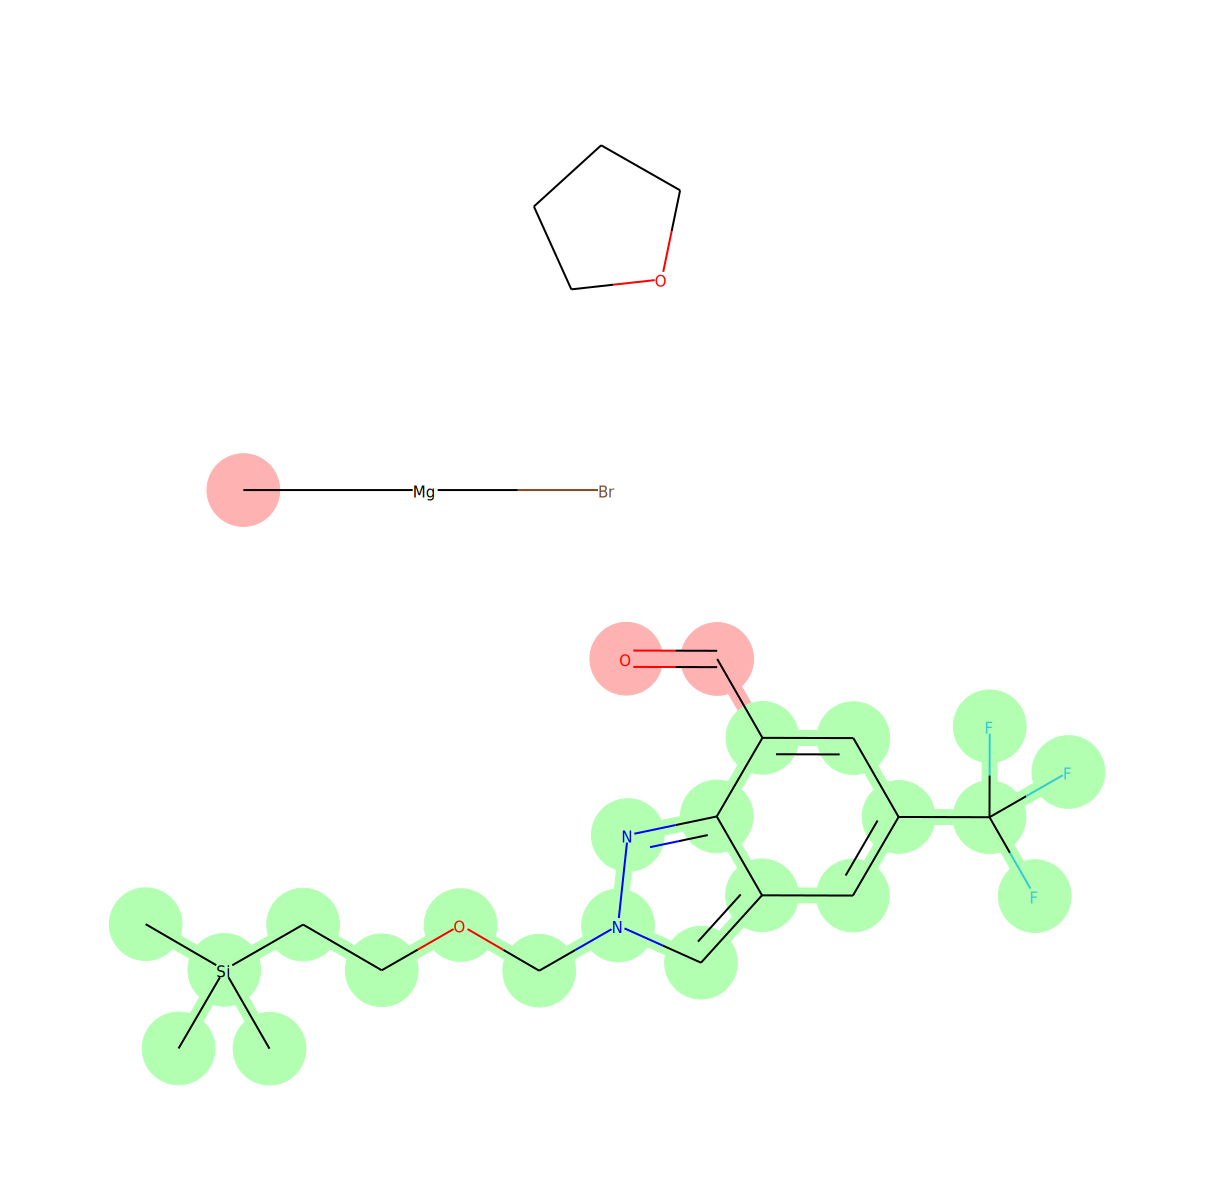

14668
1.159281


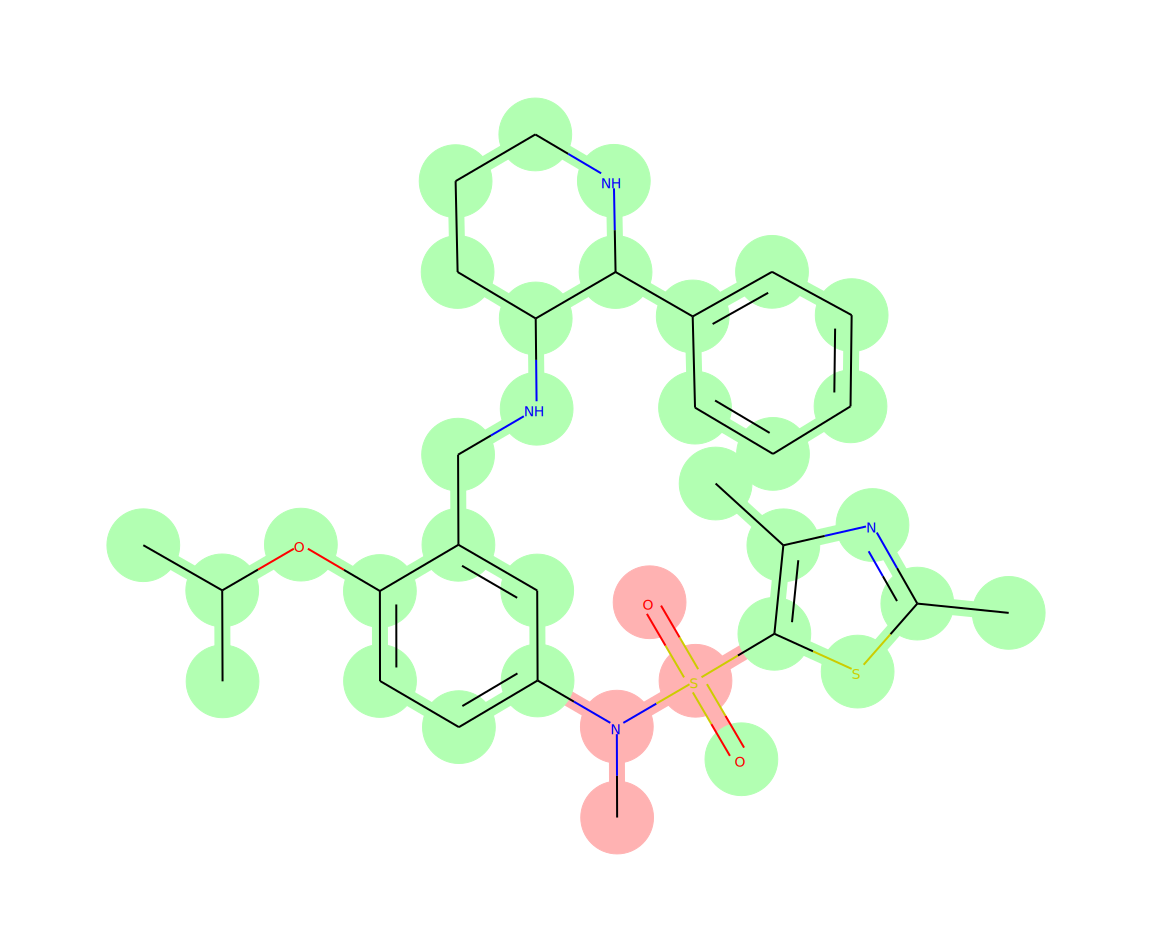

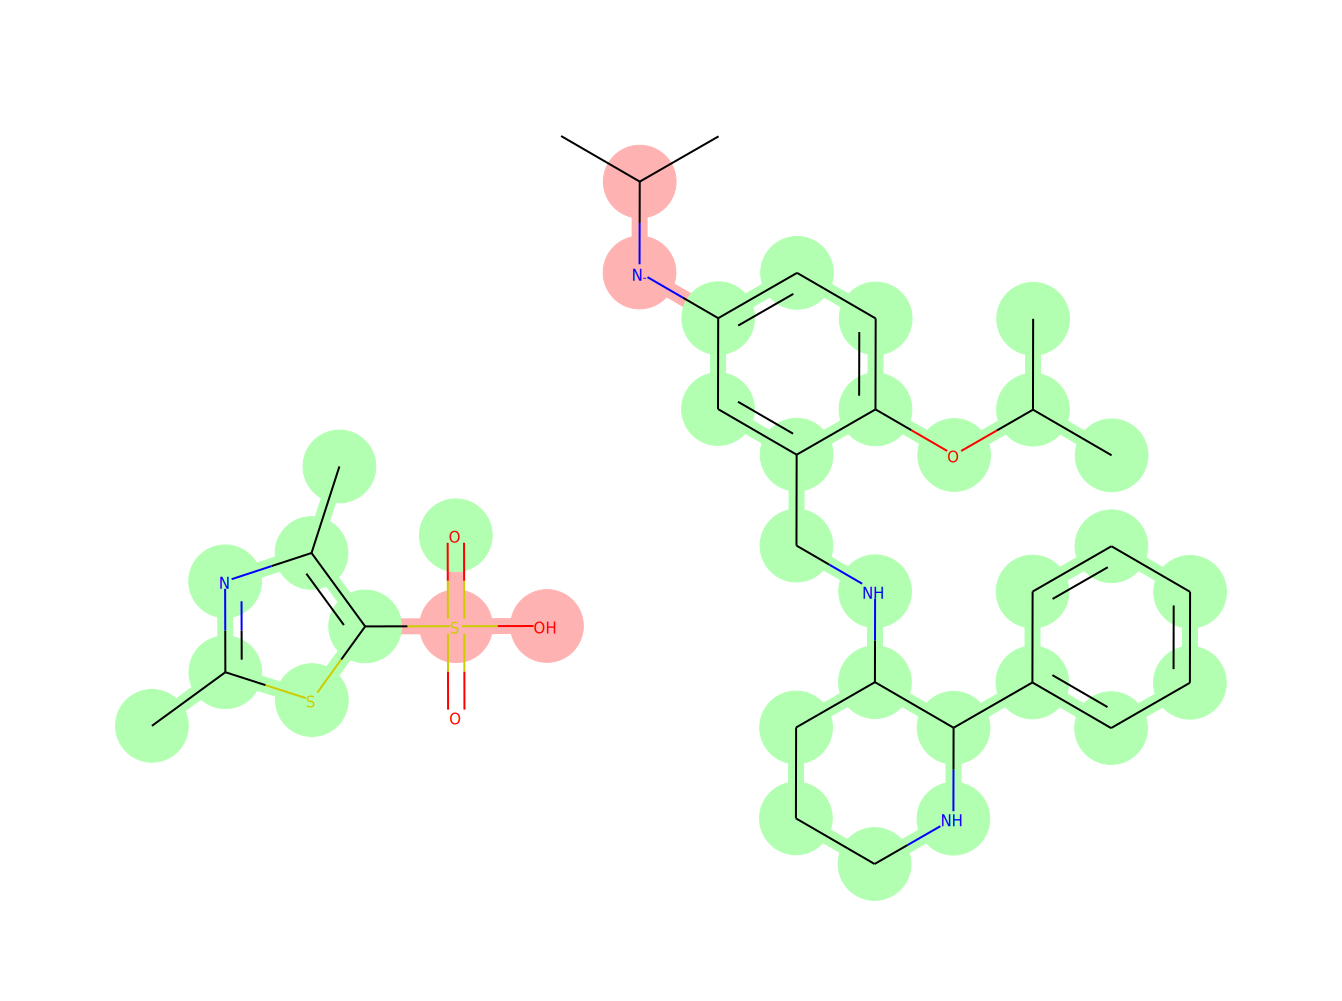

New center
1468
0.5584681


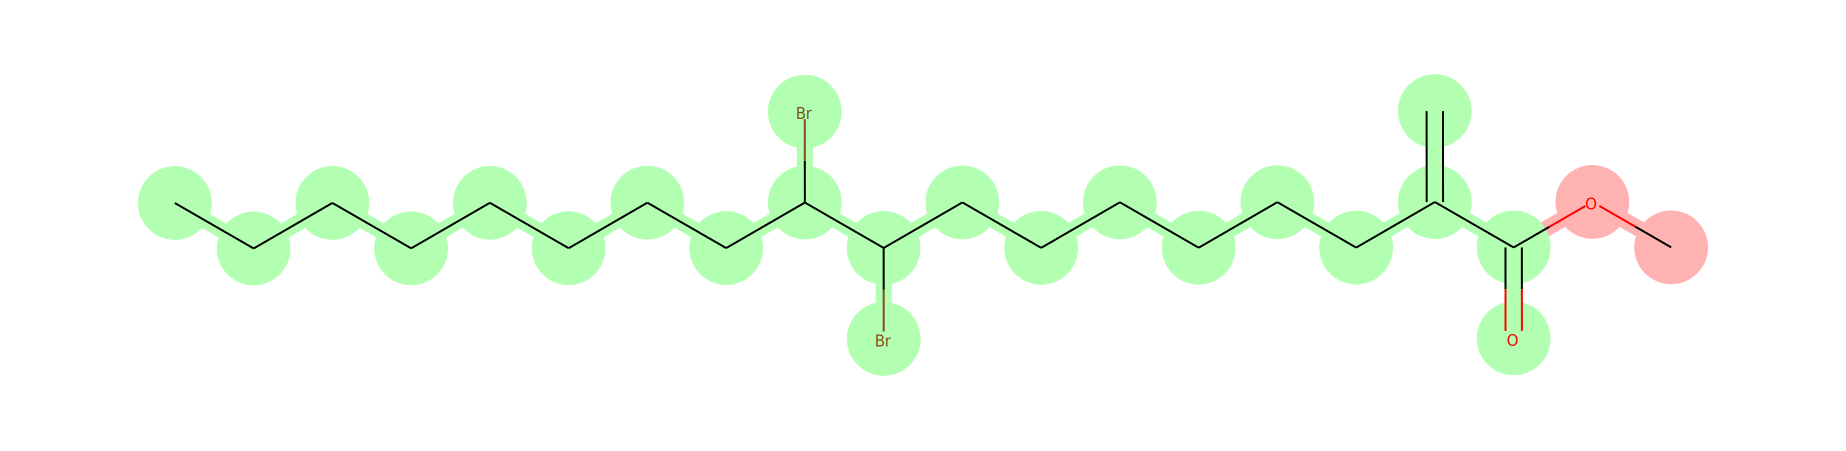

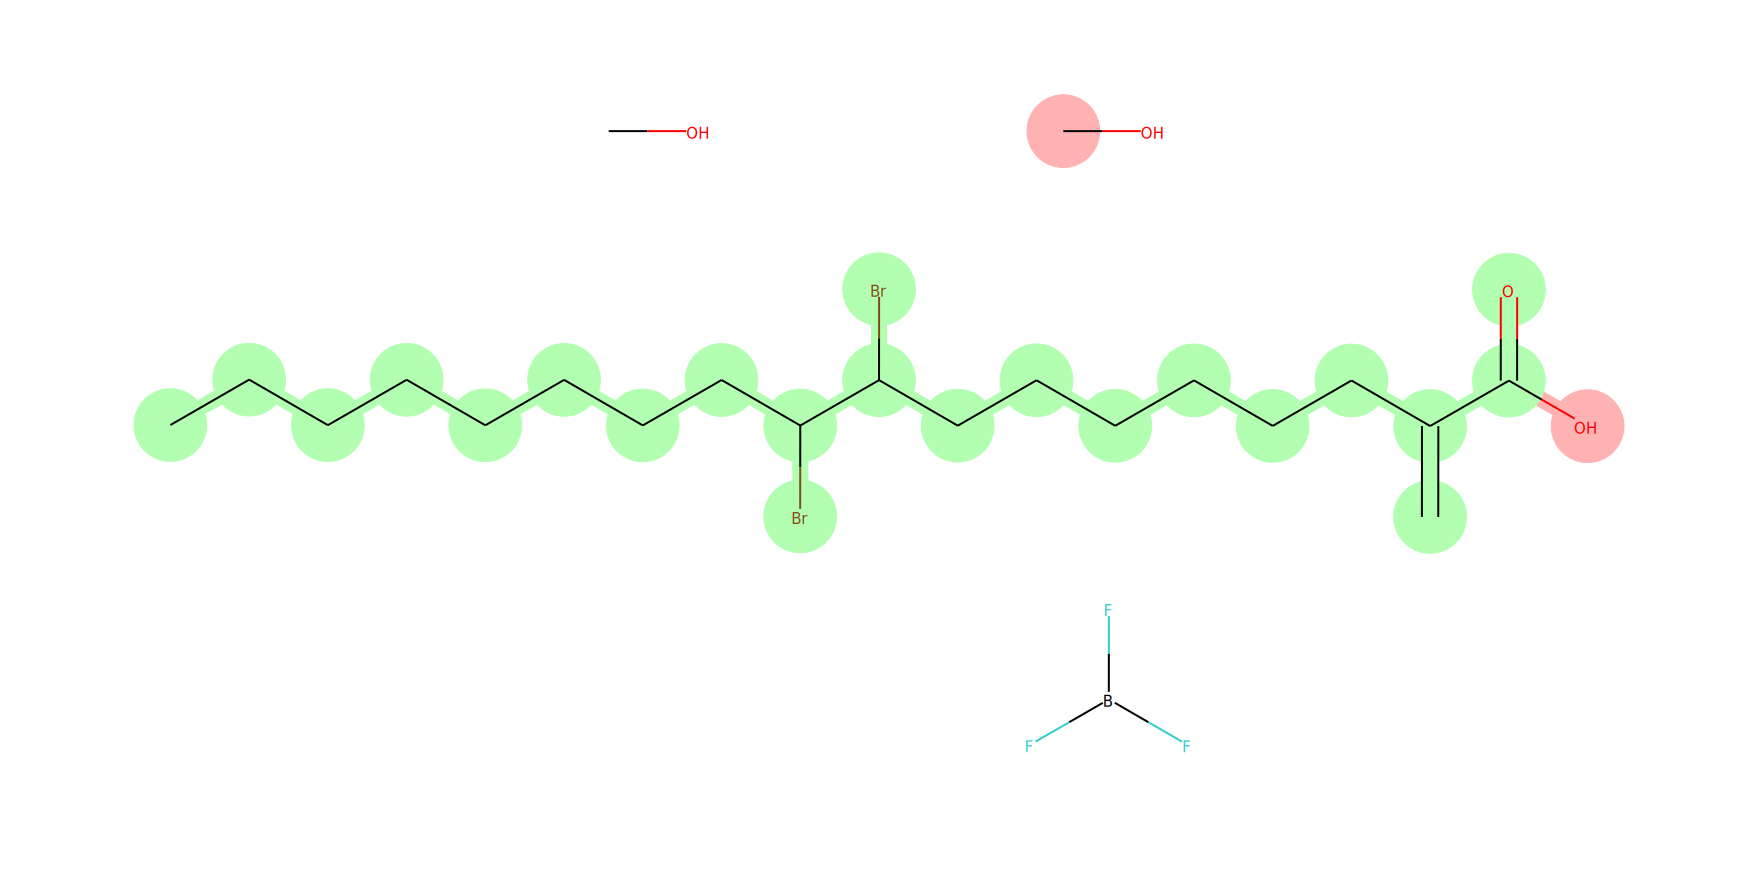

7613
0.55860525


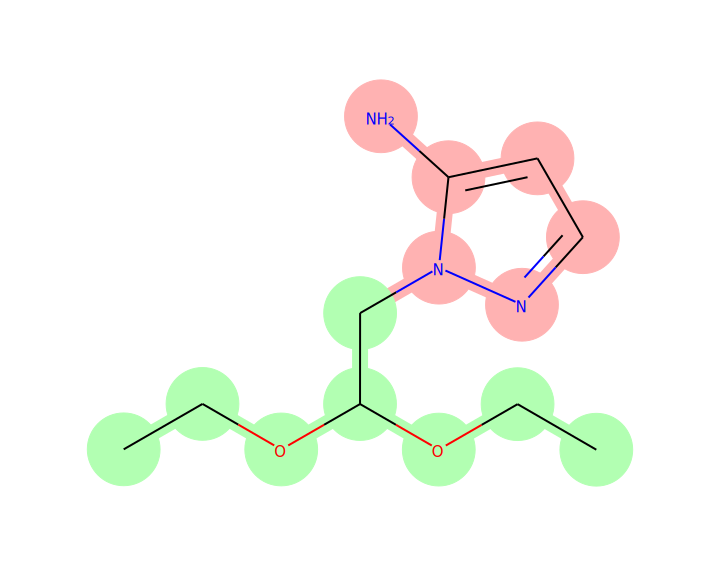

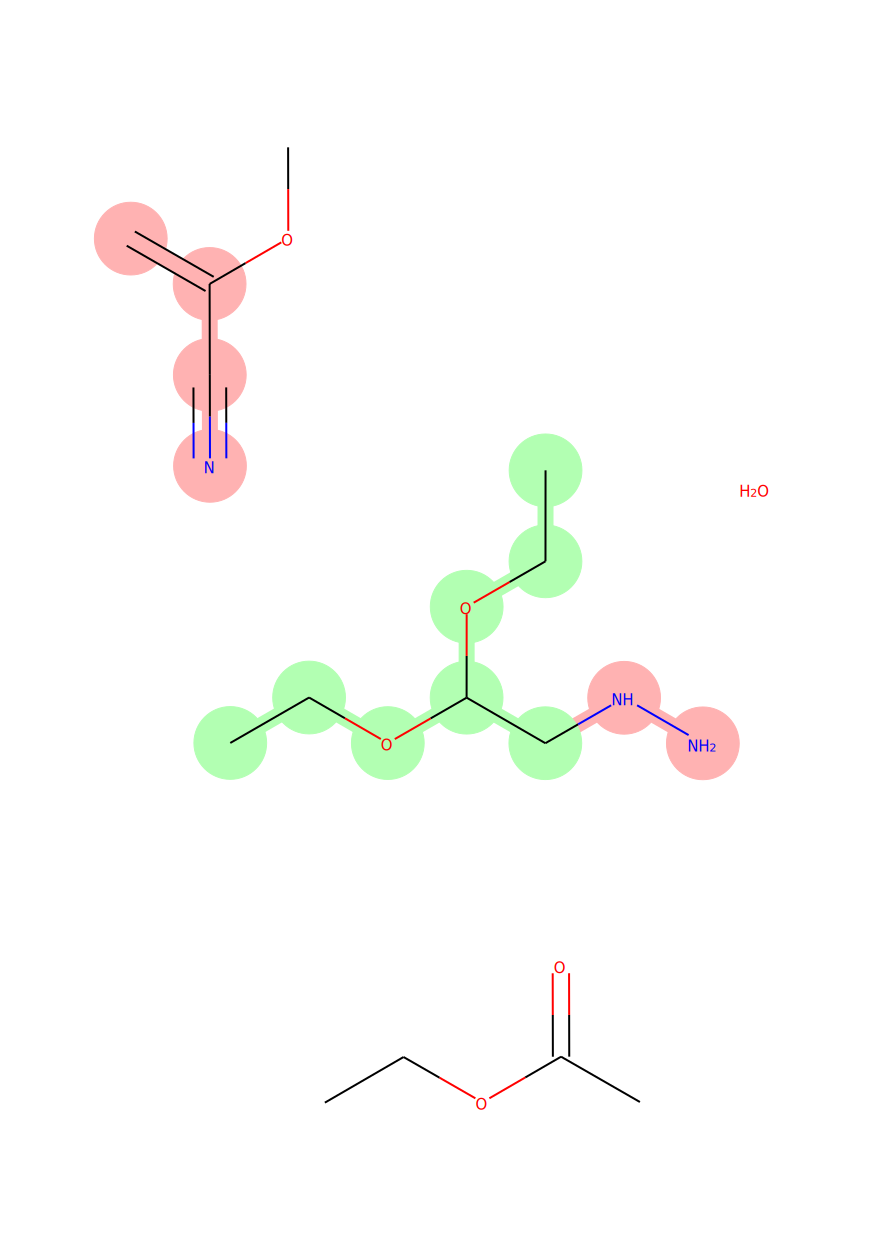

26676
0.55866224


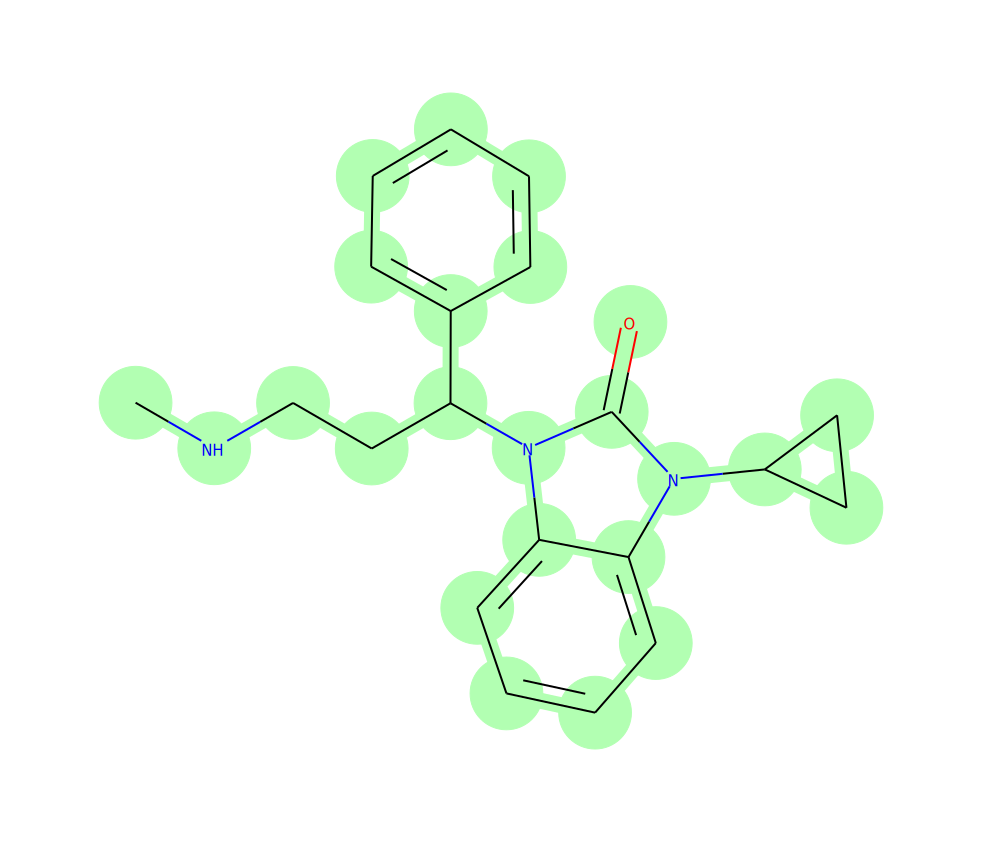

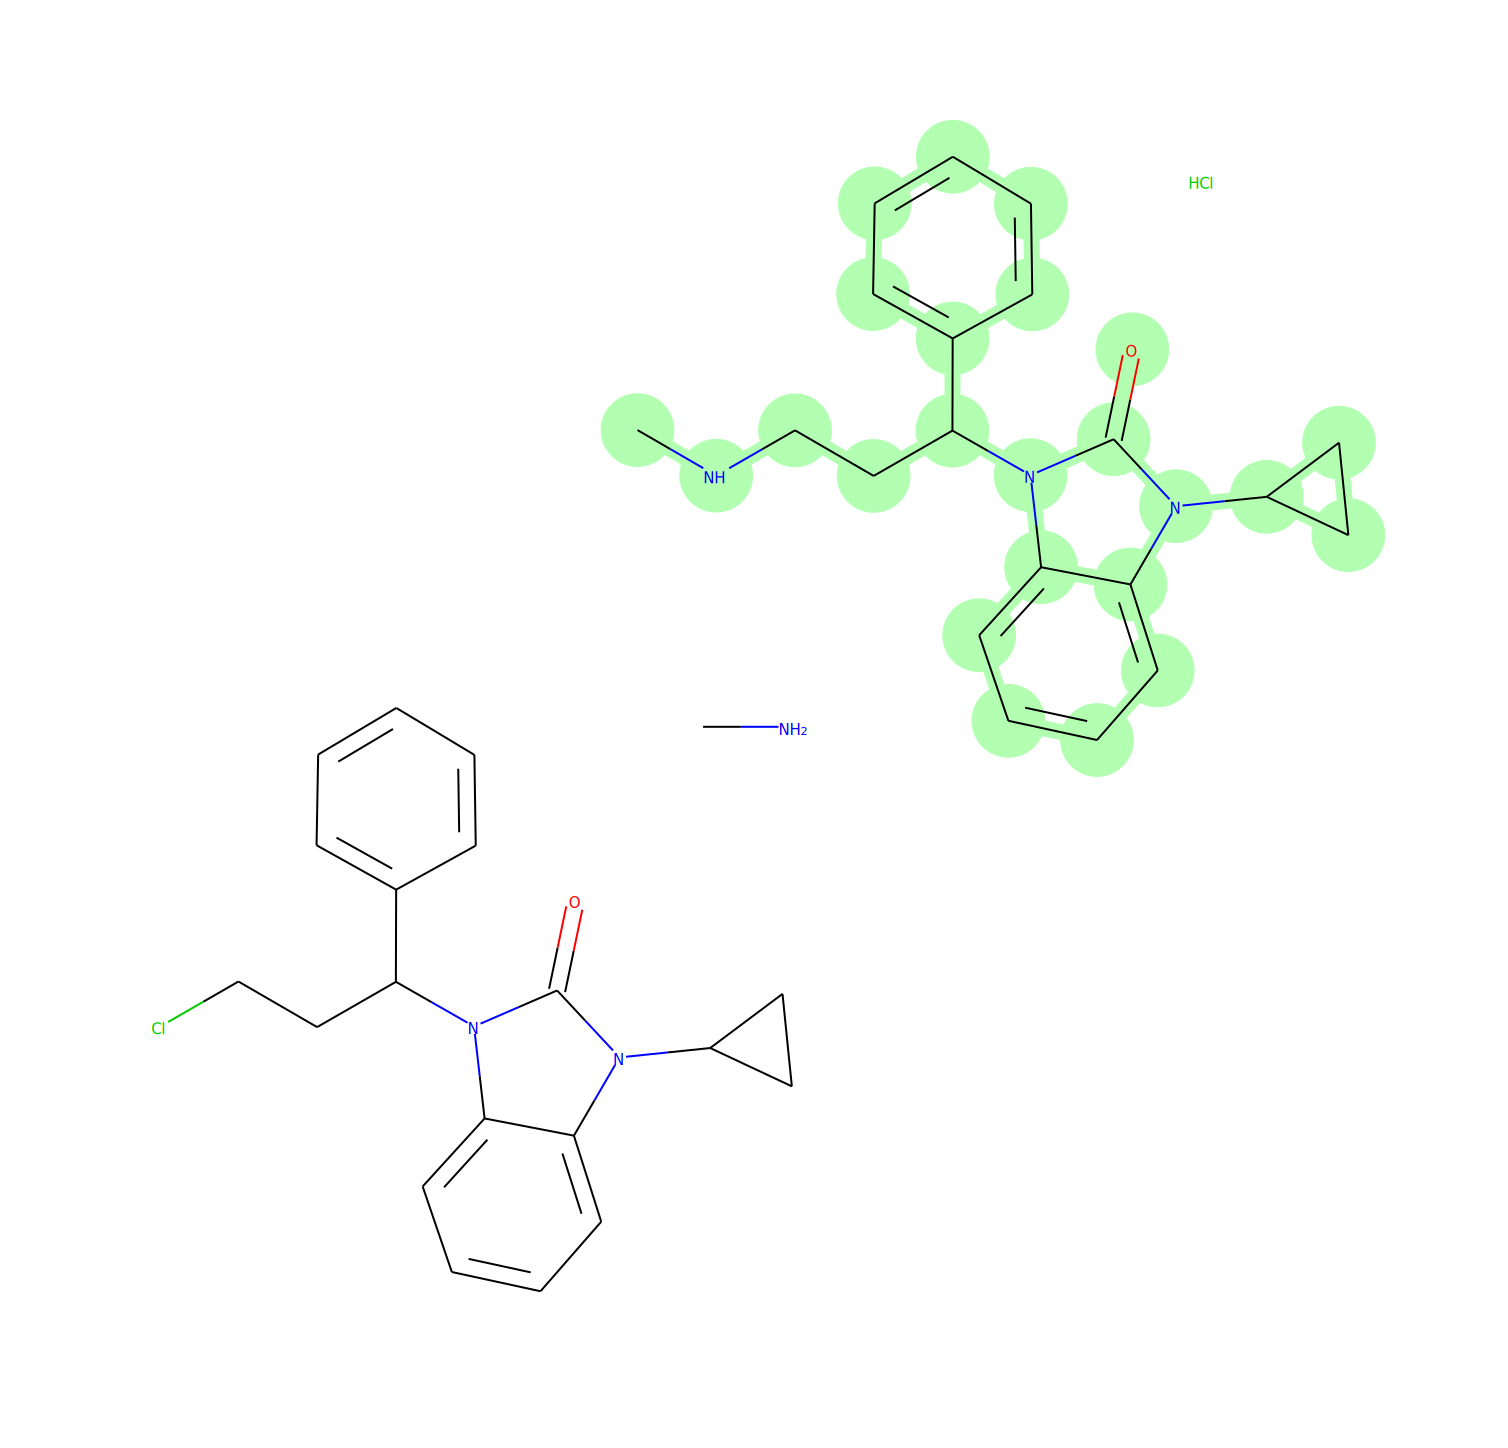

30948
0.55957305


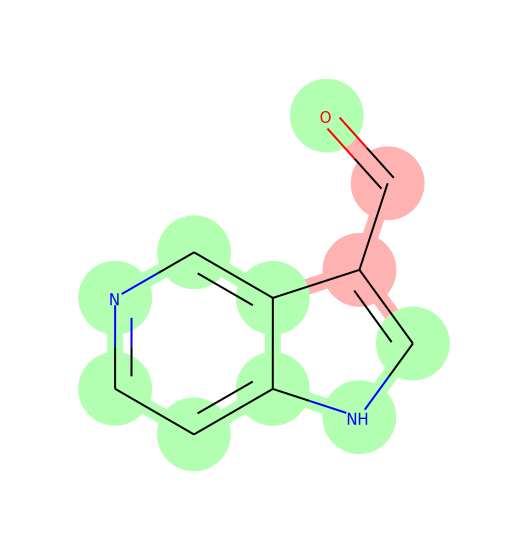

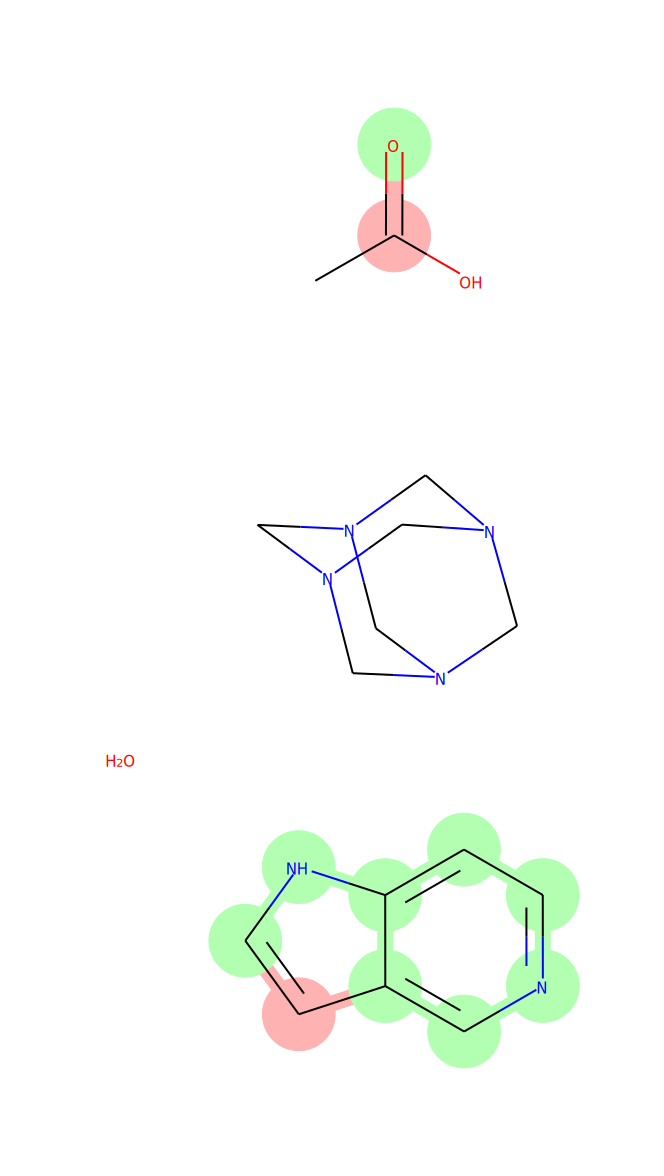

1388
0.60476696


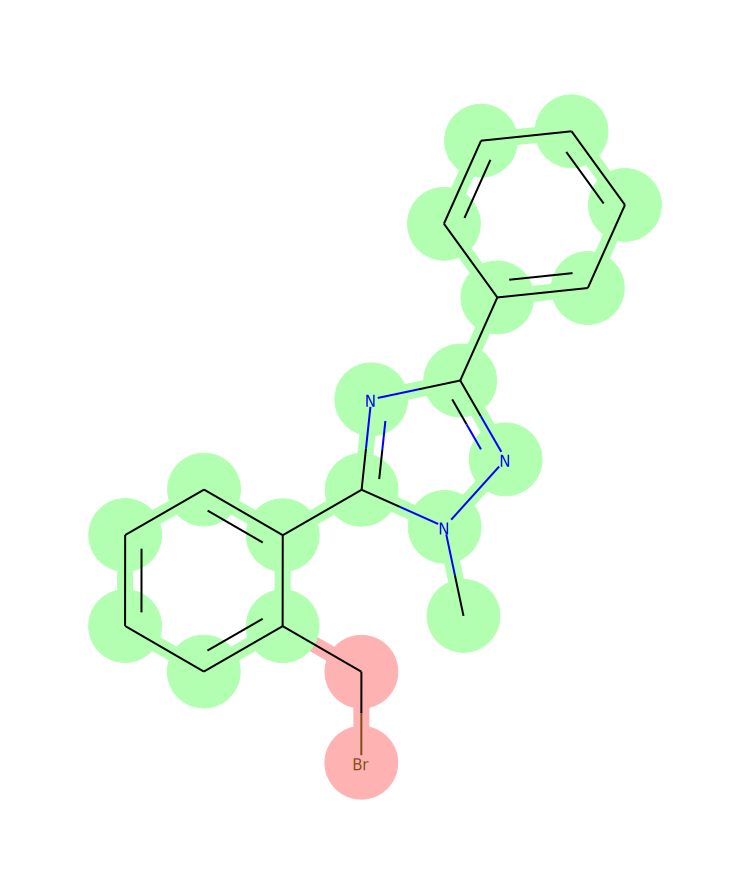

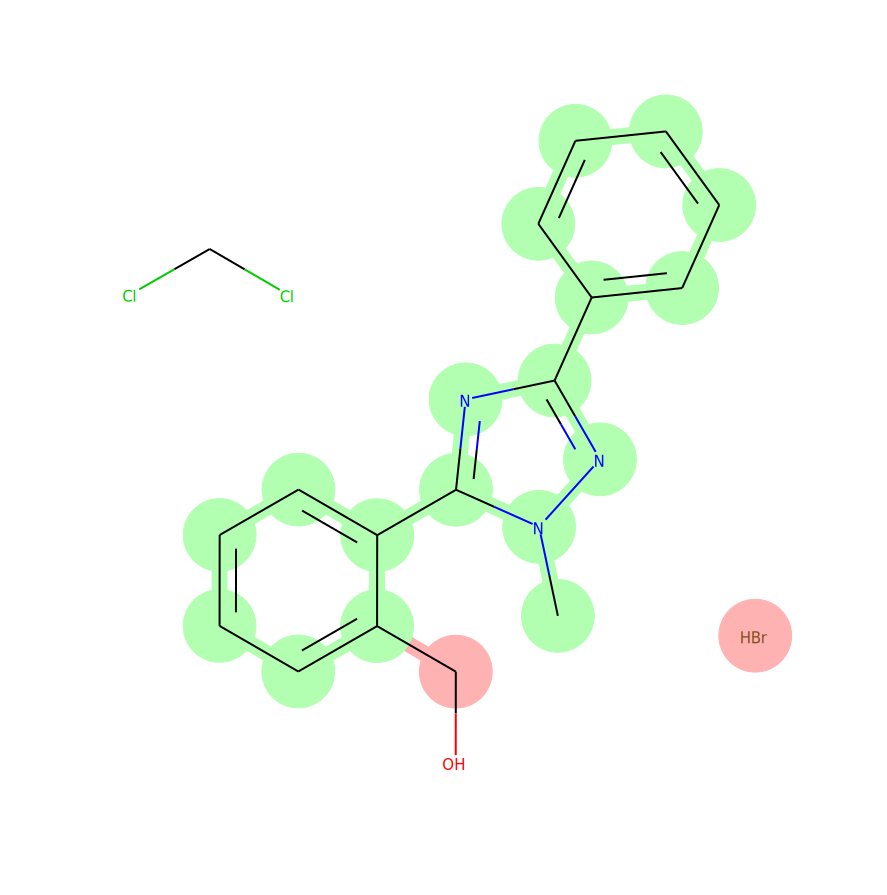

In [25]:
for center in centers:
    print('New center')
    norms = []
    for r in norm_reac_reps:
        norms.append(np.linalg.norm(r - center))
    norms = np.array(norms)
    idxs = np.argsort(norms)
    show_k_reactants(test_dataset, norms, idxs[[0, 1, 2, 50, 10000]])

In [26]:
idxs = [0, 102, 31514]#0, 88, 23890

31514
0.0


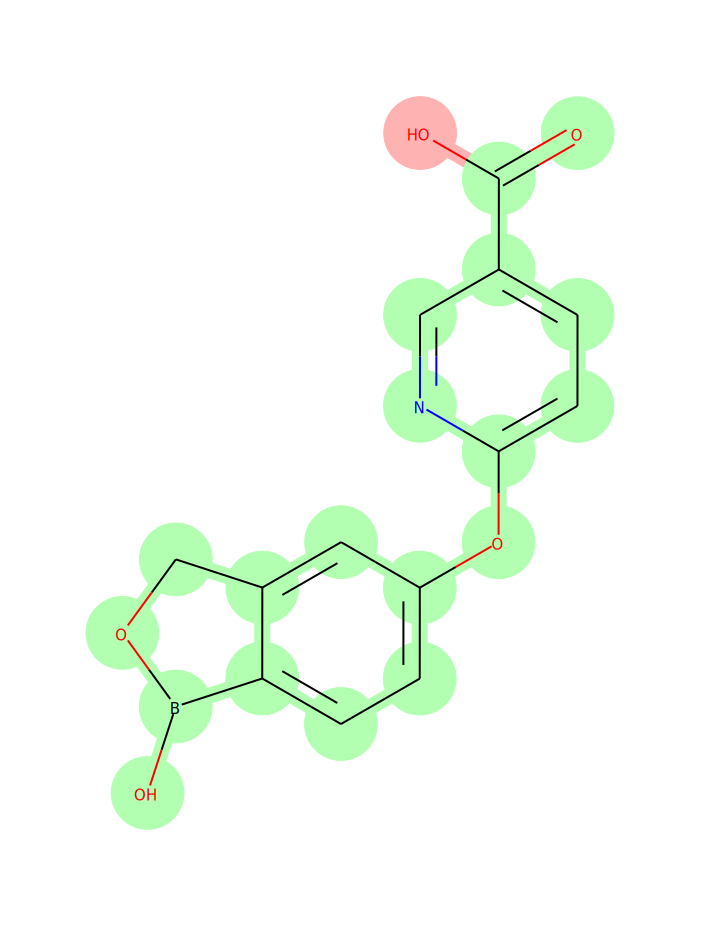

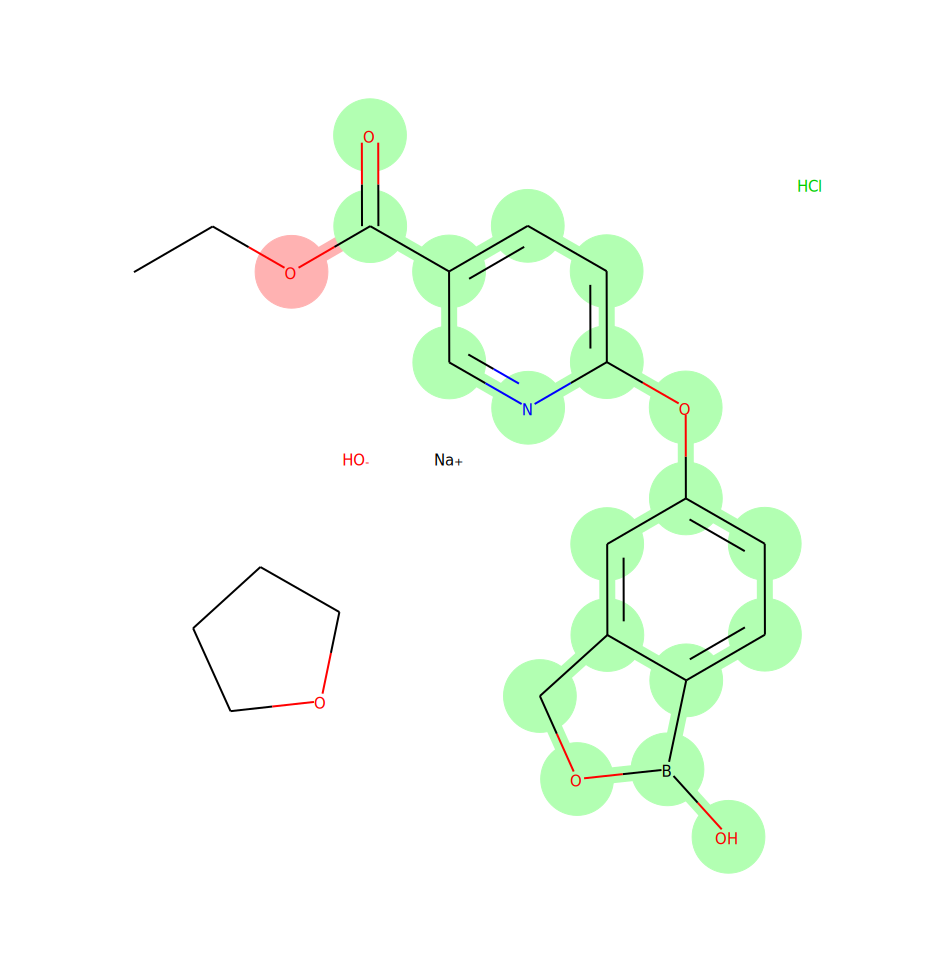

20584
0.0045694606


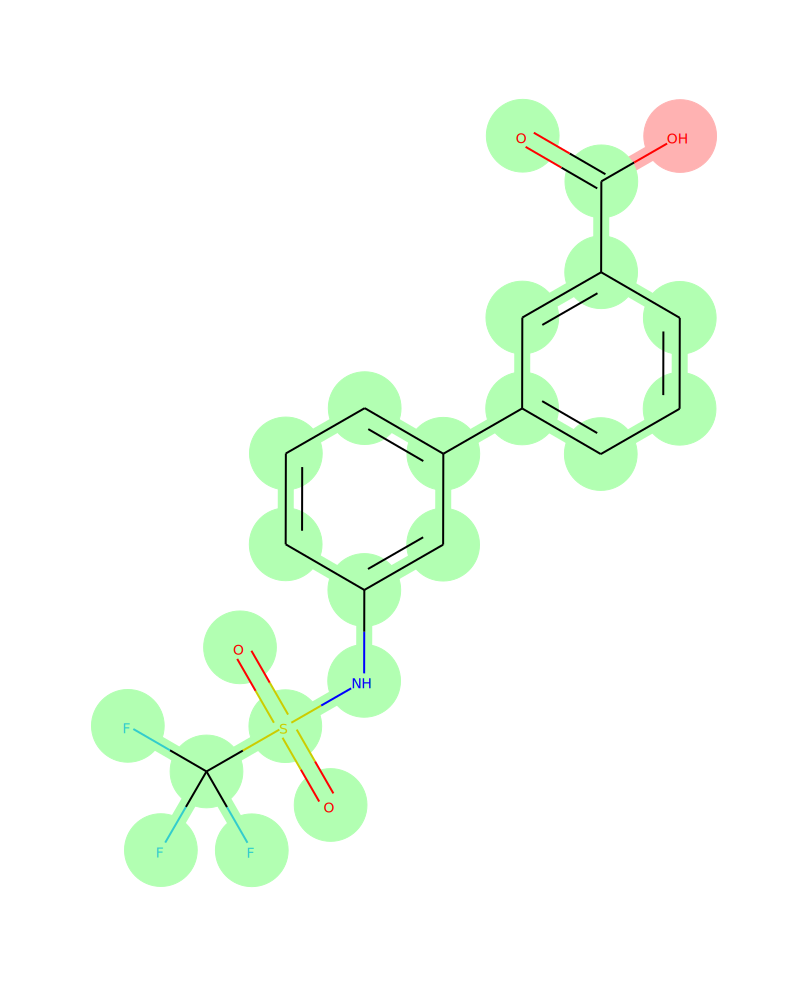

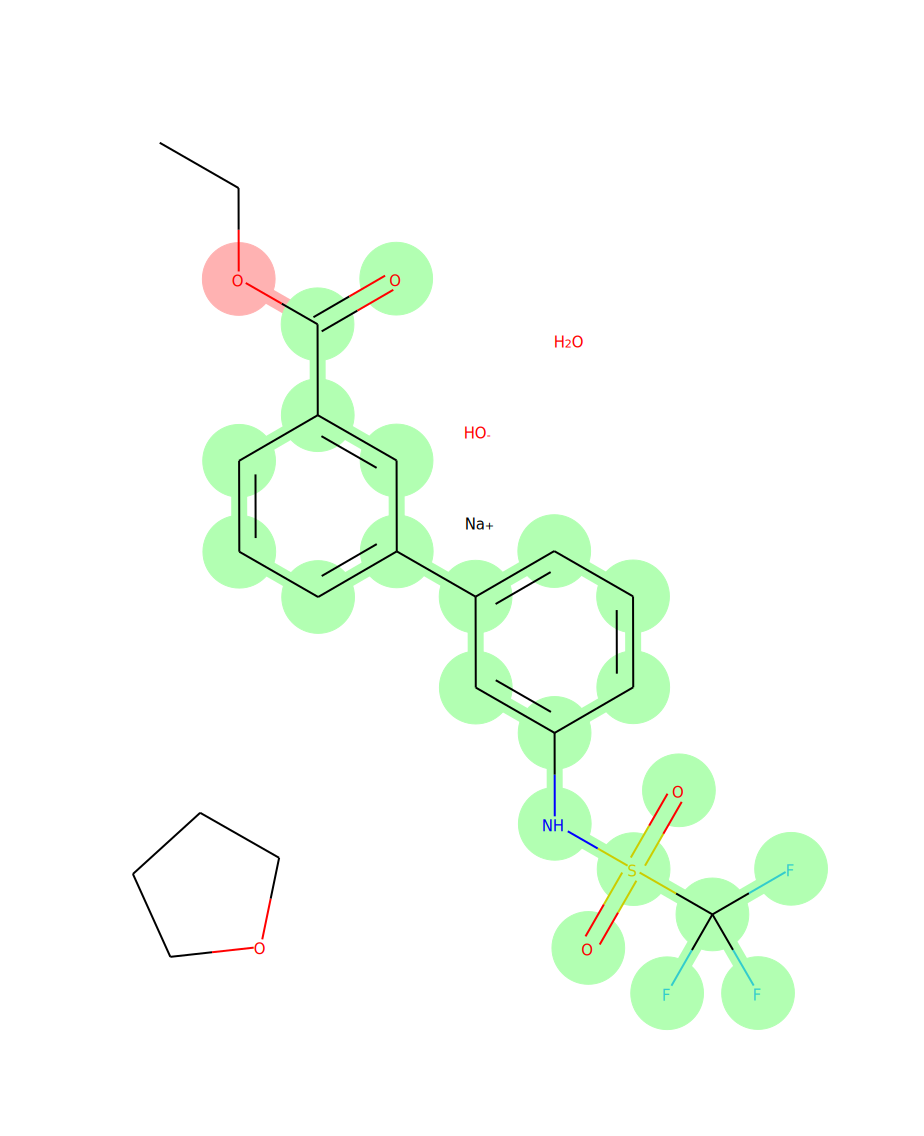

20454
0.0064547057


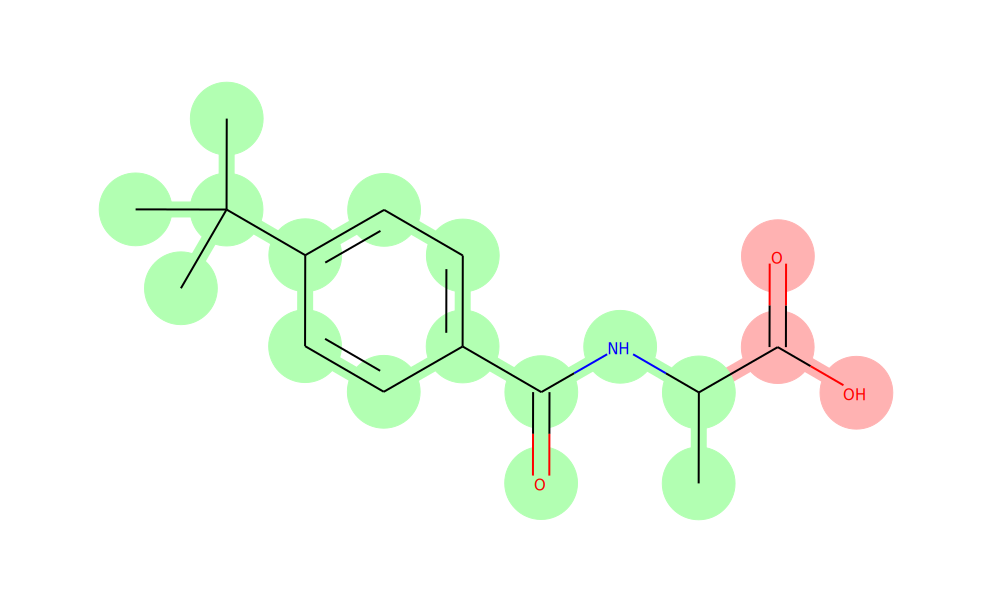

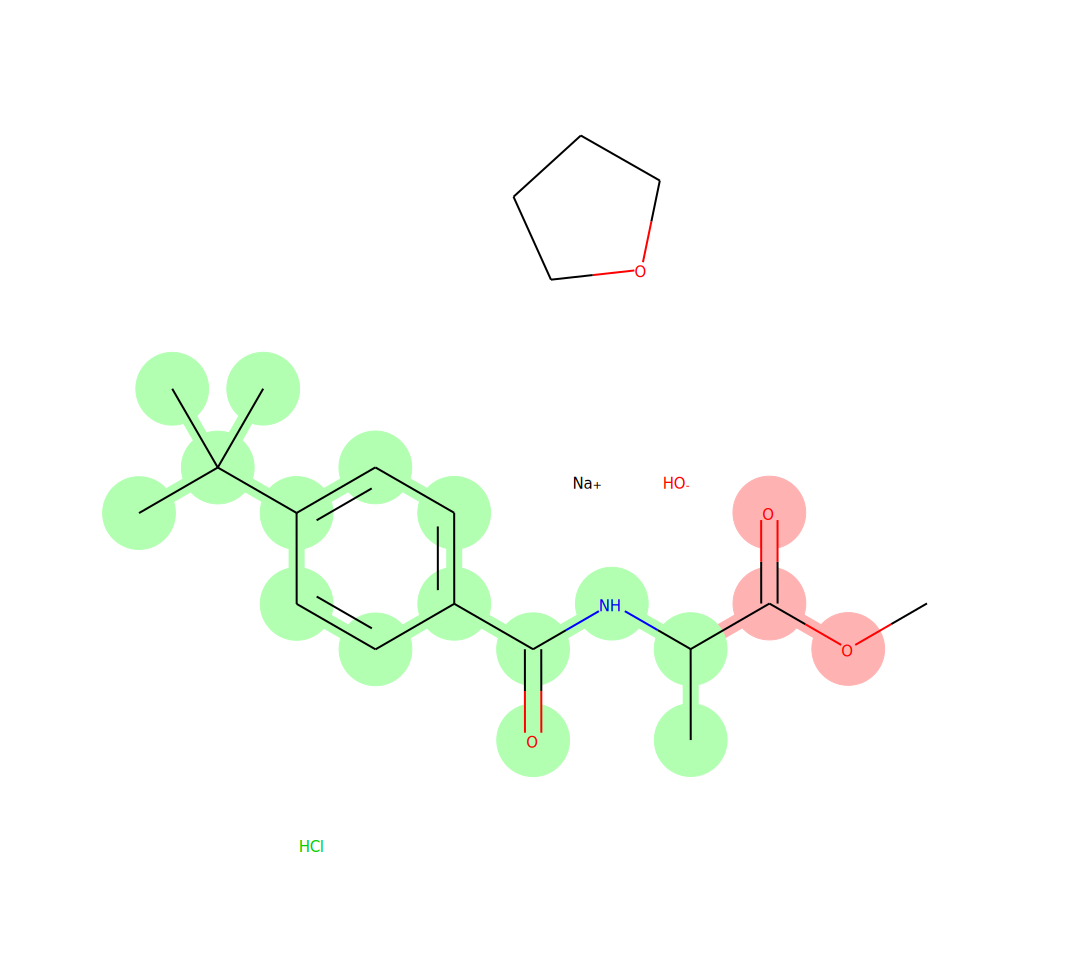

34078
0.0222137


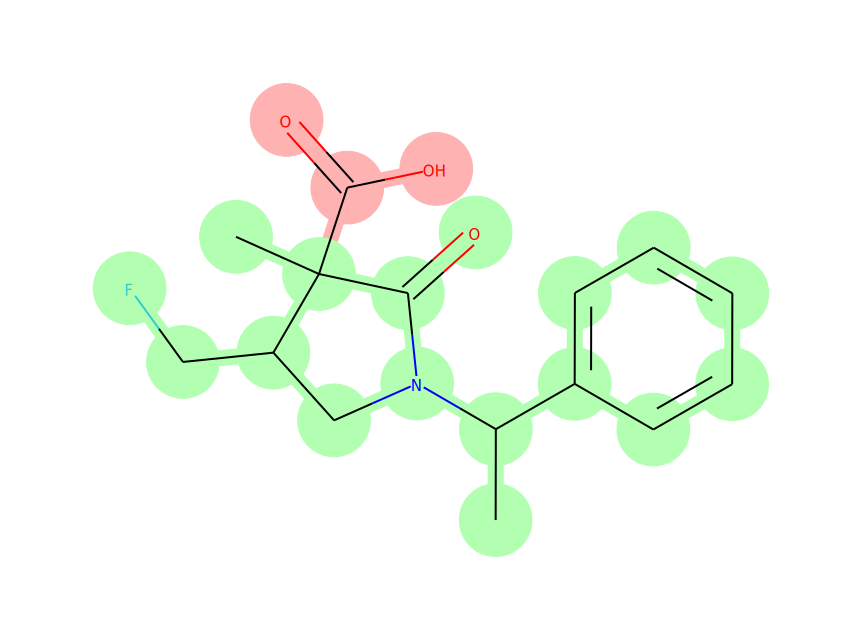

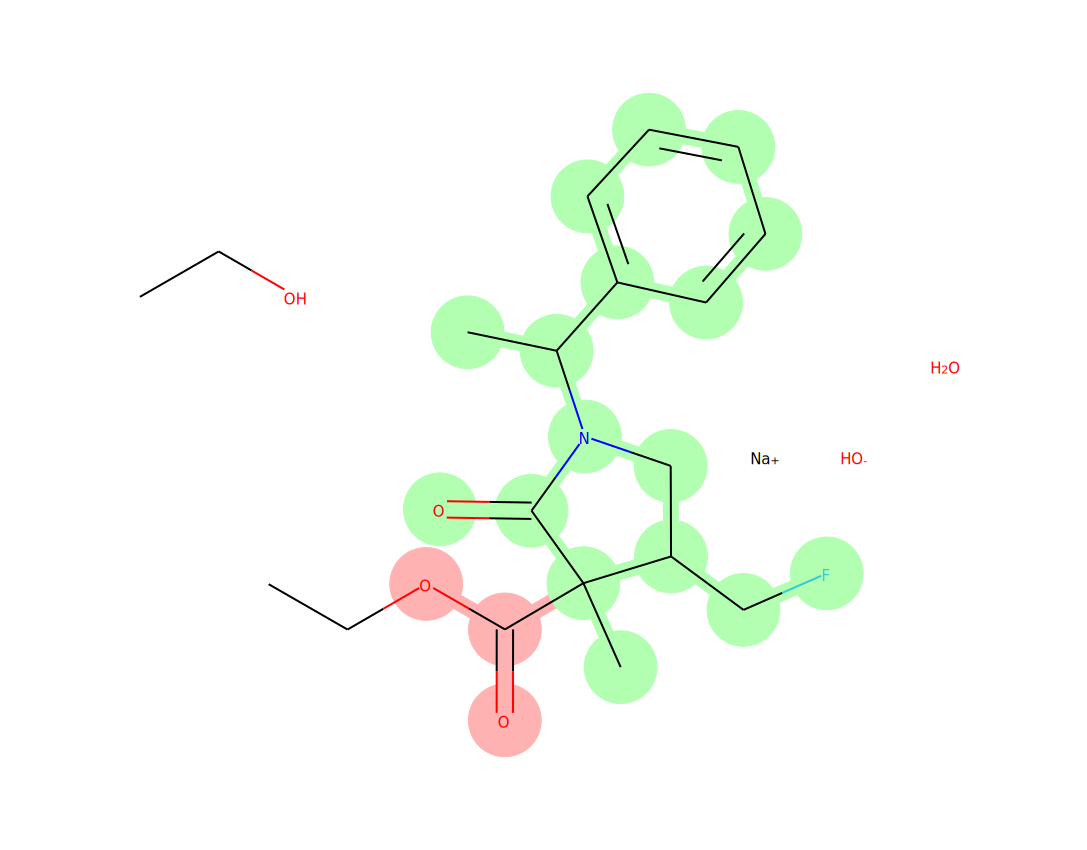

14819
0.121074624


RDKit WARNING: [19:08:54] WARNING: not removing hydrogen atom without neighbors


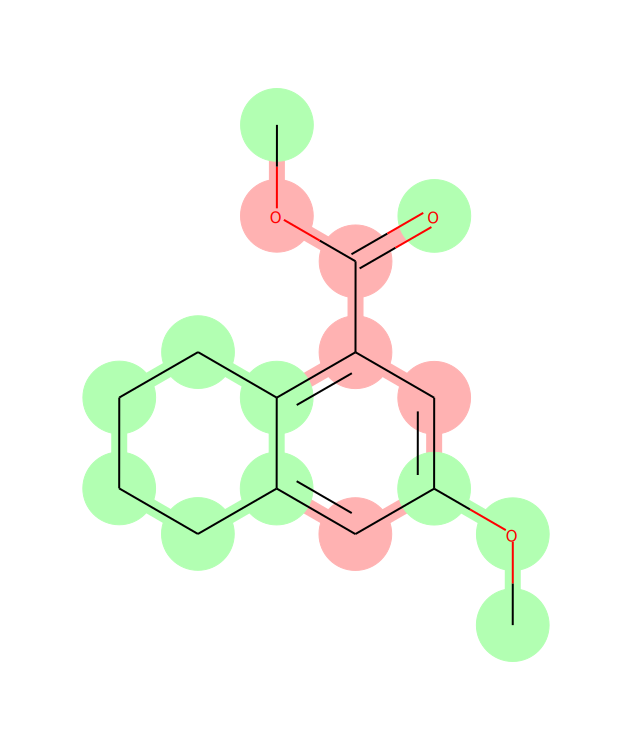

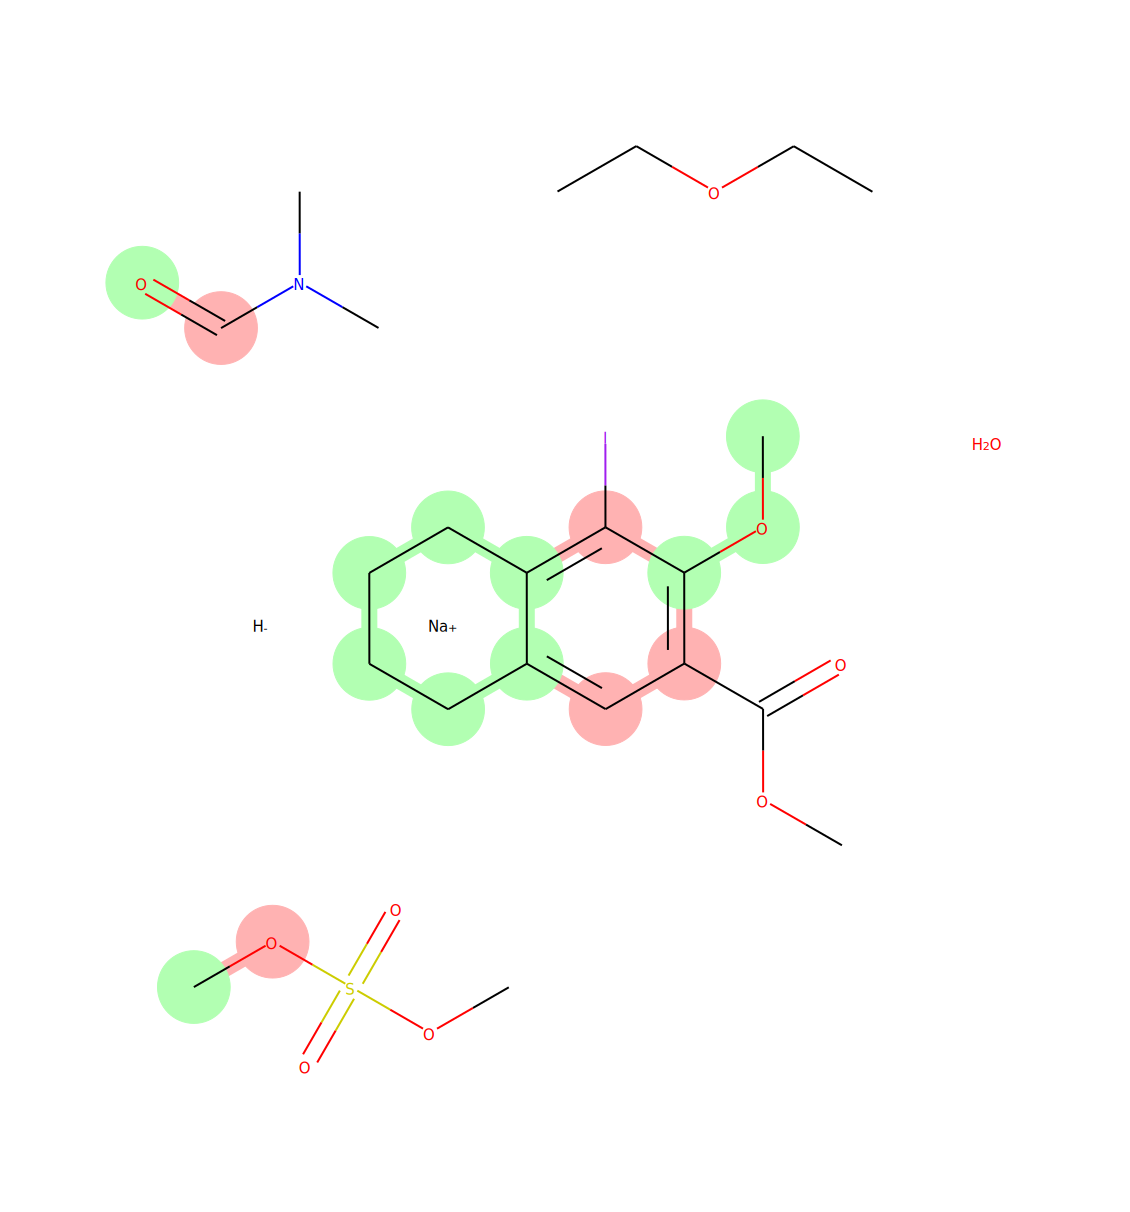

In [27]:
idx = 23890
norms = np.linalg.norm(norm_reac_reps - norm_reac_reps[idx], axis=-1)
norms = np.array(norms)
idxs = np.argsort(norms)
show_k_reactants(test_dataset, norms, idxs[[0, 1, 2, 50, 5002]])